# README

This notebook allows to recreate all plots using MD data from the manuscript (Figure 6-7 and Figure S6-S16).

# Import libraries and define functions

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import barnaba as bb
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection

sys.path.append('BME2')
import BME as BME
import BME_tools as bt

import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 5

In [3]:
def calc_chi_ensemble(exp,calc,sample_weights,noe=False):
    calc_avg = np.sum(calc*sample_weights[:,np.newaxis],axis=0)
    if noe == True:
        calc_avg = np.power(np.average(np.power(calc,-6), weights=sample_weights, axis=0),-1./6)
    diff = (calc_avg-exp[:,0])

    return  np.average((diff/exp[:,1])**2)

def calc_chi_bundle(exp,calc,noe=False):
    calc_avg = calc
    if noe == True:
        calc_avg = calc 
    diff = (calc_avg-exp[:,0])

    return  np.average((diff/exp[:,1])**2, axis=-1)

def calc_RMSE_ensemble(exp,calc,sample_weights,noe=False):
    calc_avg = np.sum(calc*sample_weights[:,np.newaxis],axis=0)
    if noe == True:
        calc_avg = np.power(np.average(np.power(calc,-6), weights=sample_weights, axis=0),-1./6)
    diff = (calc_avg-exp[:,0])
 
    return  np.sqrt(np.average(diff**2))

def calc_RMSE_bundle(exp,calc):
    diff = calc-exp[:,0]
    return np.sqrt(np.average(diff**2, axis=-1))

def calc_RMSRE_ensemble(exp,calc,sample_weights,noe=False):
    calc_avg = np.sum(calc*sample_weights[:,np.newaxis],axis=0)
    if noe == True:
        calc_avg = np.power(np.average(np.power(calc,-6), weights=sample_weights, axis=0),-1./6)
    rel_diff = ((calc_avg-exp[:,0])/exp[:,0])
 
    return  np.sqrt(np.average(rel_diff**2))

def calc_RMSRE_bundle(exp,calc):
    rel_diff = (calc-exp[:,0])/exp[:,0]
    return np.sqrt(np.average(rel_diff**2, axis=-1))

def get_angles_bundle(bundle_pdb, angles_list, res_list=['G_5_0', 'C_6_0', 'U_7_0', 'U_8_0', 'G_9_0', 'C_10_0']):
    angles_,res_ = bb.backbone_angles(bundle_pdb, residues=res_list, angles=angles_list)
    res_ = [i.split('_')[0]+i.split('_')[1] for i in res_]
    print(angles_.shape)
#     aa_ = np.copy(angles_) 
#     aa_ *= 180.0/np.pi

    return angles_

In [4]:
def get_measurement_idx(lbl_list, res, measurement):
    lbl = f'{res}:{measurement}'
    idx = lbl_list.index(lbl)
    return idx

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx #array[idx]

In [58]:
def plot_angle_measurement(res, angle, measurements, mtype, save=False): #residue='U7', angle='delta', measurements=['C1-C2', 'C3-C4'], measurement_type='ccr'/'j3'
    markers = ['d', 'H', '<', '>']
    msizes = [110, 110, 110, 110] # markersizes
    
    # if(angle=="delta"):
    #     bins=np.linspace(0.5,np.pi,90)
    #     ang_add = 0
    # elif(angle=="alpha" or angle == "beta" or angle == "gamma" or angle == "zeta" or angle == "eps"):
    #     # tors[np.where(tors<0)] += 2*np.pi
    #     ang_add = 2*np.pi
    #     bins=np.linspace(0,2*np.pi,90)
    # else:
    #     bins=np.linspace(-np.pi,np.pi,90)
    
    if(angle=="delta"):
        bins=np.linspace(0,180,45)
        # bins=np.linspace(0,360,90)
        ang_add = 0
    elif(angle=="alpha" or angle == "beta" or angle == "gamma" or angle == "zeta" or angle == "eps"):
        # tors[np.where(tors<0)] += 2*np.pi
        ang_add = 360
        bins=np.linspace(0,360,90)
    else:
        bins=np.linspace(-180,180,90)

    idxs = []
    for m in measurements:
        if mtype == 'ccr':
            idxs.append(get_measurement_idx(ccr_lbl, res, m))
            data_e, data_c, data_b = ccr_exp, ccr_calc, ccr_bundles
            ylbl = 'CCR [Hz]'
        elif mtype == 'j3':
            idxs.append(get_measurement_idx(j3_lbl, res, m))
            data_e, data_c, data_b = j3_exp, j3_calc, j3_bundles
            ylbl = r'$\mathregular{^3J}$ [Hz]'
        else:
            print('Check measurement type!')
            break


    fig, ax = plt.subplots(2,1, figsize=[10,9])
    ###### UPPER PANEL ######
    for i,idx in enumerate(idxs):
        # Exp:
        err = ax[0].errorbar(0.8+i, data_e[idx,0], yerr=data_e[idx,1], c='k', marker='s', ls='', markersize=9, elinewidth=2., capthick=2., capsize=12, zorder=10, label='Exp') # This is just for the legend
        ax[0].errorbar(0.8+i, data_e[idx,0], yerr=data_e[idx,1], c='k', marker='s', ls='', markersize=9, elinewidth=2.5, capthick=2.5, capsize=210/len(measurements), zorder=10, label='Exp')
        # MD:
        hh, ee = np.histogram(data_c[:,idx], bins=50, density=True)
        ax[0].plot((hh/hh.max()*0.1*len(measurements))+(.833+i), 0.5*(ee[1:] + ee[:-1]), c='dimgrey', lw=4, zorder=8)
        ax[0].scatter(np.array((hh/hh.max()*0.1*len(measurements))+(.833+i))[find_nearest(0.5*(ee[1:] + ee[:-1]), np.average(data_c[:,idx]))], np.average(data_c[:,idx]), marker='o', s=170, edgecolor=None, color='dimgrey', zorder=8.5)
        # MD:
        hh, ee = np.histogram(data_c[:,idx], bins=50, density=True, weights=w_rew)
        ax[0].plot((hh/hh.max()*0.1*len(measurements))+(.833+i), 0.5*(ee[1:] + ee[:-1]), c='darkgrey', lw=4, ls='--', dashes=(2,1), zorder=9)
        ax[0].scatter(np.array((hh/hh.max()*0.1*len(measurements))+(.833+i))[find_nearest(0.5*(ee[1:] + ee[:-1]), np.average(data_c[:,idx], weights=w_rew))], np.average(data_c[:,idx], weights=w_rew), marker='o', s=120, edgecolor=None, color='darkgrey',zorder=9.5)
        # MD+Exp bundle:
        ax[0].scatter([0.75+i]*len(frames), data_c[frames,idx], s=80, marker='o', color='lightgrey')#, alpha=0.7)
        ax[0].scatter([0.75+i], np.average(data_c[frames,idx], axis=0), s=230, marker='o', edgecolor='lightgrey', color='w', linewidths=4)
        # NMR Bundles + 1RNG:
        for b,bun in enumerate(bundles):
            ax[0].scatter([0.7+i-(0.07*b)]*len(data_b[bun]), data_b[bun][:,idx], s=msizes[b], marker=markers[b], color=cc[b])#, alpha=0.7)
            ax[0].scatter([0.7+i-(0.07*b)], np.average(data_b[bun][:,idx], axis=0), s=msizes[b]+110, marker=markers[b], edgecolor=cc[b], color='w', linewidths=3)

    # ax[0].set_xticks(np.arange(0.8, (0.8+i)*len(measurements)))
    ax[0].set_xticks([0.8+i for i in range(len(measurements)) ])
    ax[0].set_xticklabels([f'{res}:{lbl_dict_[m]}' for m in measurements])        
    ax[0].tick_params(axis='both', which='major', labelsize=18)
    ax[0].set_ylabel(ylbl, fontsize=20)

    ###### LOWER PANEL ######
    # MD:
    # tors[np.where(tors<0)] += 2*np.pi
    aa = aa_md[:,int(res[1:])-5,angles_bb.index(angle)]
    aa[np.where(aa<0)] += ang_add
    hh,ee = np.histogram(aa, bins=bins, density=True, weights=w0)
    ax[1].plot(0.5*(ee[1:]+ee[:-1]), hh, c='dimgrey', lw=4, label='MD')
    # MD+Exp:
    hh,ee = np.histogram(aa, bins=bins, density=True, weights=w_rew)
    ax[1].plot(0.5*(ee[1:]+ee[:-1]), hh, c='darkgrey', lw=4, ls='--', label='MD', dashes=(2,1))
    # MD+Exp bundle:
    ax[1].scatter(aa[frames], [-0.18/180*np.pi]*len(aa[frames]), s=80, marker='o', color='lightgrey')#, alpha=0.7)
    # NMR bundles and 1RNG:
    for b,bun in enumerate(bundles):
        aa = aa_bundles[bun][:,int(res[1:])-5,angles_bb.index(angle)]
        aa[np.where(aa<0)] += ang_add
        ax[1].scatter(aa, [(-b/4/180*np.pi)-0.4/180*np.pi]*len(aa), s=msizes[b], marker=markers[b], color=cc[b])#, alpha=0.7)


    ax[1].set_xticks(np.arange(0,bins.max()+1,bins.max()/4))
    ax[1].tick_params(axis='both', which='major', labelsize=18)
    ax[1].set_xlabel(r'$\mathregular{{s1}}$ [$\degree$] '.replace('s1', '\\'+angle), fontsize=20)
    ax[1].set_ylabel('Density', fontsize=20)
    # Custom legend:
    handles1 =  [Line2D([0], [0], lw=4, color='dimgrey', label='MD'),
                 Line2D([0], [0], lw=4, ls='--', dashes=(2,1), color='darkgrey', label='MD+Exp'),
                 Line2D([0], [0], lw=4, ls='', color='lightgrey', marker='o', markersize=8, label='Bundle MD+Exp')]
    handles2 =  [Line2D([0], [0], lw=4, ls='', color=cc[i], marker=markers[i], markersize=msizes[i]/10, label=ii) for i,ii in enumerate(['Bundle E', 'Bundle F','1RNG']) ]
    fig.legend(handles=[item for sublist in [[err], handles1, handles2] for item in sublist], fontsize=16, ncol=4, loc='center', bbox_to_anchor=(0.53, 0.52), fancybox=True) #, edgecolor='k'

    plt.tight_layout(h_pad=6.5)
    if save == True:
        plt.savefig(f'plots/{res}_{angle}_{"_".join(measurements)}.pdf')
        # plt.savefig(f'plots/{res}_{angle}_{"_".join(measurements)}.png', dpi=300)
    plt.show()

In [7]:
cc = ['#56B4E9', '#009E74', '#D55C00', '#F0E442', '#826aed', '#ff90b3', '#f7d9a7']
markers = ['d', 'H', '<', '>', 'o', 'v','D']
msizes = [110, 110, 110, 110, 80, 110, 80] # markersizes

In [8]:
bundles = ['E', 'F', '1RNG']

x_lbl = ['MD', 'MD+Exp', 'Bundle\nMD+Exp', 'Bundle E', 'Bundle F', '1RNG']

In [9]:
lbl_dict_ = {
    # 3J:
    "C4Pb": r"$\rm ^3J(C4'_{i}\!,\!P_{i})$",
    "C4Pe": r"$\rm ^3J(C4'_{i}\!,\!P_{i\!+\!1})$",
    "1H5P": r"$\rm ^3J(H5'\!,\!P_{i})$",
    "2H5P": r"$\rm ^3J(H5''\!,\!P_{i})$",
    "1H5H4": r"$\rm ^3J(H4'\!,\!H5')$",
    "2H5H4": r"$\rm ^3J(H4'\!,\!H5'')$",
    "H1H2": r"$\rm ^3J(H1'\!,\!H2')$",
    "H2H3": r"$\rm ^3J(H2'\!,\!H3')$",
    "H3H4": r"$\rm ^3J(H3'\!,\!H4')$",
    "H3P": r"$\rm ^3J(H3'\!,\!P_{i\!+\!1})$",
    
    # CCR:
    "C1-C2": r"$\rm \Gamma^{DD\!,\!DD}_{(C1'H1'\!,\!C2'H2')}$",
    "C3-C4": r"$\rm \Gamma^{DD\!,\!DD}_{(C3'H3'\!,\!C4'H4')}$",
    "C4p-P": r"$\rm \Gamma^{DD\!,\!CSA}_{(C4'_iH4_i\!,\!P_{i})}$",
    "C3p-P-plus": r"$\rm \Gamma^{DD\!,\!CSA}_{(C3'_iH3_i\!,\!P_{i\!+\!1})}$",
    "C4p-P-plus": r"$\rm \Gamma^{DD\!,\!CSA}_{(C4'_iH4_i\!,\!P_{i\!+\!1})}$",
            }

# Load Data

## RDC

In [47]:
rdc_lbl  = list(pd.read_csv('exp_data/exp_rdc_pales.tab', delim_whitespace=True, usecols=[0]).index)
rdc_exp  = np.loadtxt('exp_data/exp_rdc_loop_bme.dat', usecols=[1,2])
rdc_calc = np.loadtxt(f'calc_data/calc_rdc_loop_bme.dat')[:,1:]
rdc_exp_all = np.loadtxt('exp_data/exp_rdc_bme.dat', usecols=[1,2])
rdc_calc_all = np.loadtxt(f'calc_data/calc_rdc_bme.dat')[:,1:]
L_calc = np.sum(rdc_exp_all[:,0]*np.average(rdc_calc_all, axis=0))/np.sum(np.average(rdc_calc_all, axis=0)*np.average(rdc_calc_all, axis=0))
print('L_calc = ', L_calc)

rdc_bundles = {}
L_bundles = {}
for f in bundles:
    rdc_bundles[f] = np.loadtxt(f'nmrbundle_data/nmrbundle_{f}_rdc_loop_bme.dat')[:,1:]
    L_bundles[f] = np.load(f'nmrbundle_data/nmrbundle_{f}_rdc_all_bme_L.npy') 

L_calc =  -0.6983543150473638


## $^3$J

In [19]:
j3_lbl  = list(pd.read_csv('exp_data/exp_j3_bme.dat', delim_whitespace=True, usecols=[0]).index)
j3_lbl = [ f"{i.split('-')[0]}:{i.split('-')[1]}" for i in j3_lbl ]
j3_exp   = np.loadtxt('exp_data/exp_j3_bme.dat', usecols=[1,2])
j3_calc  = np.loadtxt('calc_data/calc_j3_bme.dat')[:,1:]
j3_bundles = {}
for f in bundles:
    j3_bundles[f] = np.loadtxt(f'nmrbundle_data/nmrbundle_{f}_j3_loop_bme.dat')[:,1:]

## CCR

In [20]:
ccr_lbl  = list(pd.read_csv('exp_data/exp_ccr.dat', delim_whitespace=True, usecols=[0]).index)
ccr_exp  = np.loadtxt('exp_data/exp_ccr.dat', usecols=[1,2])
ccr_calc = np.loadtxt('calc_data/calc_ccr_bme.dat')[:,1:]
ccr_bundles = {}
for f in bundles:
    ccr_bundles[f] = np.loadtxt(f'nmrbundle_data/nmrbundle_{f}_ccr_loop_bme.dat')[:,1:]

## NOE

In [23]:
noe_lbl  = list(pd.read_csv('exp_data/exp_noe_loop_bme.dat', delim_whitespace=True, usecols=[0])['#'])
noe_exp = np.loadtxt(f'exp_data/exp_noe_loop_bme.dat', usecols=[1,2])
noe_calc = np.loadtxt(f'calc_data/calc_dists_loop_bme.dat')[:,1:]
noe_bundles = {}
for f in bundles:
    noe_bundles[f] = np.loadtxt(f'nmrbundle_data/nmrbundle_{f}_dists_loop_bme.dat')[:,1:]

## MD sub-ensemble frames

In [24]:
frames = []
with open('md_plus_exp_subsampled.pdb', 'r') as f:
    lines = f.readlines()
    
for l in lines:
    if l.startswith('REMARK   FRAME'):
        frames.append((int(l.split()[-1])))
frames = np.array(frames)

In [25]:
frames

array([19076, 13602, 12389, 17022, 16440,  2427, 16134,   862, 18867,
        2996,  8287,  1491, 10818, 18072, 11697, 14349,  2853,  2015,
        1507, 11796,  6770, 14381, 13366,   651, 15784,  7002,  2944,
        9643,  1522, 11689,  1942, 10447,  1516,  8947, 18684,  2439,
       12080,  5820, 18592,  6096,  2708, 13841,  2427,  8373,  3863,
        1491, 11664, 14325,  9110, 16835, 11789,  2857,  6963,  6986,
        9997,  8691, 10632,  8188,  5621,  2921, 10834, 12926, 17034,
       10911,  1479,  9493, 18243, 14394, 16086, 18297,  9685,  6681,
       11804,  6951, 18050, 18511,   380,  8652, 13128, 11811,  4460,
       13932, 11671,  1105,  6681, 18282, 18532,  8929, 10632, 13919,
       18426, 11779, 14303,  4563, 18163,  9560,  9086, 14393,  4294,
       11284])

# Reweight simulations using 3J and RDC

## SI Fig: k-fold cross-validation

In [26]:
thetas = np.geomspace(0.1, 20000, 30)
kfold = np.load('reweighting/crossval_J3_RDC_results.npy')

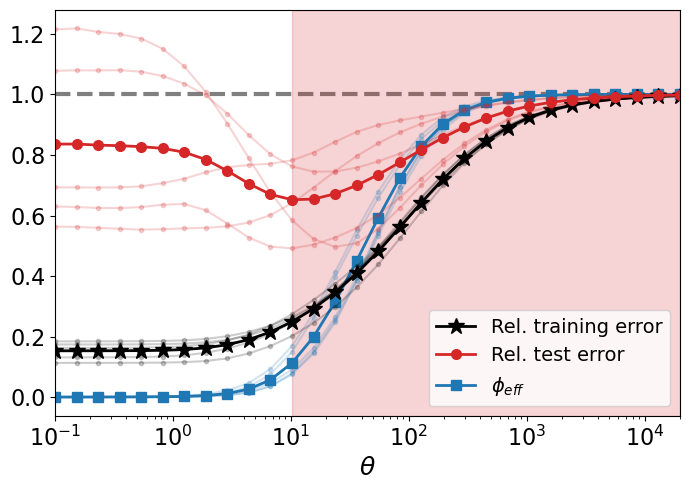

In [27]:
plt.figure(figsize=[7,5])

plt.plot(thetas, kfold[:,:,0], ls='-', alpha=0.2, marker='.', c='k')
plt.plot(thetas, np.average(kfold[:,:,0], axis=1), lw=2, marker='*', c='k', markersize=12, label='Rel. training error')
plt.plot(thetas, kfold[:,:,1], ls='-', alpha=0.2, marker='.', c='tab:red')
plt.plot(thetas, np.average(kfold[:,:,1], axis=1), lw=2, marker='o', c='tab:red', markersize=7, label='Rel. test error')
plt.plot(thetas, kfold[:,:,2], ls='-', alpha=0.2, marker='.', c='tab:blue', zorder=-1)
plt.plot(thetas, np.average(kfold[:,:,2], axis=1), lw=2, marker='s', c='tab:blue', markersize=7, label=r'$\phi_{eff}$', zorder=-1)
plt.axhline(1, ls='--', c='k', lw=3, alpha=.5, zorder=-10)
plt.axvspan(thetas[np.average(kfold[:,:,1], axis=1).argmin()], thetas.max(), color='tab:red', alpha=0.2, zorder=-10)

plt.xlim([thetas.min(), thetas.max()])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$\theta$', fontsize=18)
plt.xscale('log')
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('plots/rw_kfold.pdf', facecolor='w')
# plt.savefig('plots/rw_kfold.png', dpi=300, facecolor='w')
plt.show()

## SI Fig: cross-validation with CCR and NOE

In [29]:
tmp_data = np.load(f'reweighting/J3_RDC_theta_chi2_phi.npy') 
tmp_wopt = np.load(f'reweighting/J3_RDC_weights.npy')

In [30]:
w0 = np.full(rdc_calc.shape[0], 1/rdc_calc.shape[0])

In [34]:
rmse_cv = []
rmse_cv_init = np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[:,:]*L_calc, w0), calc_RMSE_ensemble(j3_exp, j3_calc[:,:], w0), calc_RMSE_ensemble(ccr_exp, ccr_calc[:,:], w0), calc_RMSE_ensemble(noe_exp, noe_calc[:,:], w0, noe=True)])

for ww in tmp_wopt:
    rmse_cv.append(np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[:,:]*L_calc, ww), calc_RMSE_ensemble(j3_exp, j3_calc[:,:], ww), calc_RMSE_ensemble(ccr_exp, ccr_calc[:,:], ww), calc_RMSE_ensemble(noe_exp, noe_calc[:,:], ww, noe=True)])/rmse_cv_init)
rmse_cv = np.array(rmse_cv)

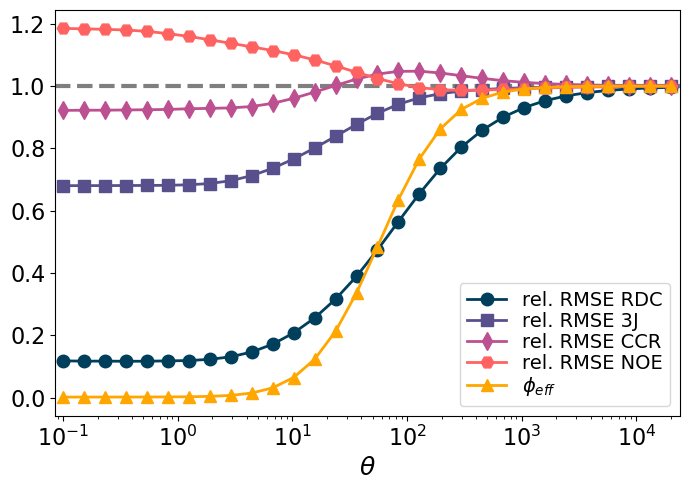

In [36]:
ccc = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']
plt.figure(figsize=[7,5])

plt.plot(tmp_data[:,0], rmse_cv[:,0], marker='o', color=ccc[0], lw=2, markersize=9, label=r'rel. RMSE RDC')
plt.plot(tmp_data[:,0], rmse_cv[:,1], marker='s', color=ccc[1], lw=2, markersize=8, label=r'rel. RMSE 3J')
plt.plot(tmp_data[:,0], rmse_cv[:,2], marker='d', color=ccc[2], lw=2, markersize=9, label=r'rel. RMSE CCR')
plt.plot(tmp_data[:,0], rmse_cv[:,3], marker='H', color=ccc[3], lw=2, markersize=9, label=r'rel. RMSE NOE')
plt.plot(tmp_data[:,0], tmp_data[:,2], marker='^', color=ccc[4], lw=2, markersize=9, label=r'$\phi_{eff}$')
plt.axhline(1, ls='--', c='k', lw=3, alpha=.5, zorder=-1)

plt.xlim(tmp_data[:,0].min()*0.85,tmp_data[:,0].max()*1.2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$\theta$', fontsize=18)
plt.legend(fontsize=14, labelspacing=0.1)
plt.xscale('log')

plt.tight_layout()
plt.savefig('plots/rw_crossval_rmse.pdf', facecolor='w')
# plt.savefig('plots/rw_crossval_rmse.png', dpi=300, facecolor='w')
plt.show()

## Reweight with selected $\theta$=23

In [39]:
rdc_exp_f  = 'exp_data/exp_rdc_loop_bme.dat'#'/storage1/kummerer/TETRALOOPS/CUUG/exp_data/for_bme/cuugrdc_loop308_bme.dat'
rdc_calc_f = 'calc_data/calc_rdc_loop_bme.dat'# '/storage1/kummerer/TETRALOOPS/PDB_SEARCH/CUUG/analysis/data/rdcs/rdc_loop_pf1_bme.dat'
j3_exp_f   = 'exp_data/exp_j3_bme.dat'# '/storage1/kummerer/TETRALOOPS/CUUG/exp_data/loop_bme_data_sandro/J3_all.txt'
j3_calc_f  = 'calc_data/calc_j3_bme.dat'# '/storage1/kummerer/TETRALOOPS/CUUG/md/cuug_subsampled/data/loop_bme_data_sandro/PDB_MD_J3_all_calc.dat'

In [41]:
# initialise BME:
rew = BME.Reweight(f'reweight_RDC_J3')
# load the experimental and calculated datasets note the "scale" 
rew.load(rdc_exp_f, rdc_calc_f, fit='scale', fit_slope=-0.6983543150473638) # Check this slope!!!
print('RDCs included.')
rew.load(j3_exp_f, j3_calc_f)
print('J3 included.')

theta = 23

chi2_before, chi2_after, phi = rew.fit(theta=theta)
w_rew = rew.get_weights()
w0 = rew.get_w0()

print("%10s %10s %10s" % (" ","Original","Optimized"))
print("%10s %10.3f %10.3f" % ("Chi2",chi2_before,chi2_after))
print("Phi_eff: %6.2f" % phi)

RDCs included.
J3 included.
             Original  Optimized
      Chi2      6.667      2.175
Phi_eff:   0.20


# Calculate RMSE and $\chi^2$

In [42]:
rmse_md = {}
rmse_md['MD'] = np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[:,:]*L_calc, w0), calc_RMSE_ensemble(j3_exp, j3_calc[:,:], w0), calc_RMSE_ensemble(ccr_exp, ccr_calc[:,:], w0), calc_RMSE_ensemble(noe_exp, noe_calc[:,:], w0, noe=True)])
rmse_md['MD+Exp'] = np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[:,:]*L_calc, w_rew[:]), calc_RMSE_ensemble(j3_exp, j3_calc[:,:], w_rew[:]), calc_RMSE_ensemble(ccr_exp, ccr_calc[:,:], w_rew[:]), calc_RMSE_ensemble(noe_exp, noe_calc[:,:], w_rew[:], noe=True)])

w0_100 = np.array([1/100]*100)
rmse_md['Bundle MD+Exp'] = np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[frames,:]*L_calc, w0_100), calc_RMSE_ensemble(j3_exp, j3_calc[frames,:], w0_100), calc_RMSE_ensemble(ccr_exp, ccr_calc[frames,:], w0_100), calc_RMSE_ensemble(noe_exp, noe_calc[frames,:], w0_100, noe=True)])

In [48]:
rmse_bundles = {}
for f in bundles:
    rmse_bundles[f] = np.array([calc_RMSE_bundle(rdc_exp, (rdc_bundles[f][:,:].T*L_bundles[f]).T), calc_RMSE_bundle(j3_exp, j3_bundles[f][:,:]), calc_RMSE_bundle(ccr_exp, ccr_bundles[f][:,:]), calc_RMSE_bundle(noe_exp, noe_bundles[f][:,:])])

# Plot RMSE and $\chi^2$


RDC [Hz]
MD: 6.80
MD+Exp: 2.11
Bundle
MD+Exp: 1.92
E: 7.25
F: 7.63
1RNG: 10.71

3J [Hz]
MD: 2.70
MD+Exp: 2.25
Bundle
MD+Exp: 2.28
E: 3.70
F: 3.68
1RNG: 4.40

CCR [Hz]
MD: 5.66
MD+Exp: 5.66
Bundle
MD+Exp: 5.86
E: 8.37
F: 9.34
1RNG: 8.40

NOE [$\AA$]
MD: 0.52
MD+Exp: 0.55
Bundle
MD+Exp: 0.60
E: 0.74
F: 0.75
1RNG: 1.22


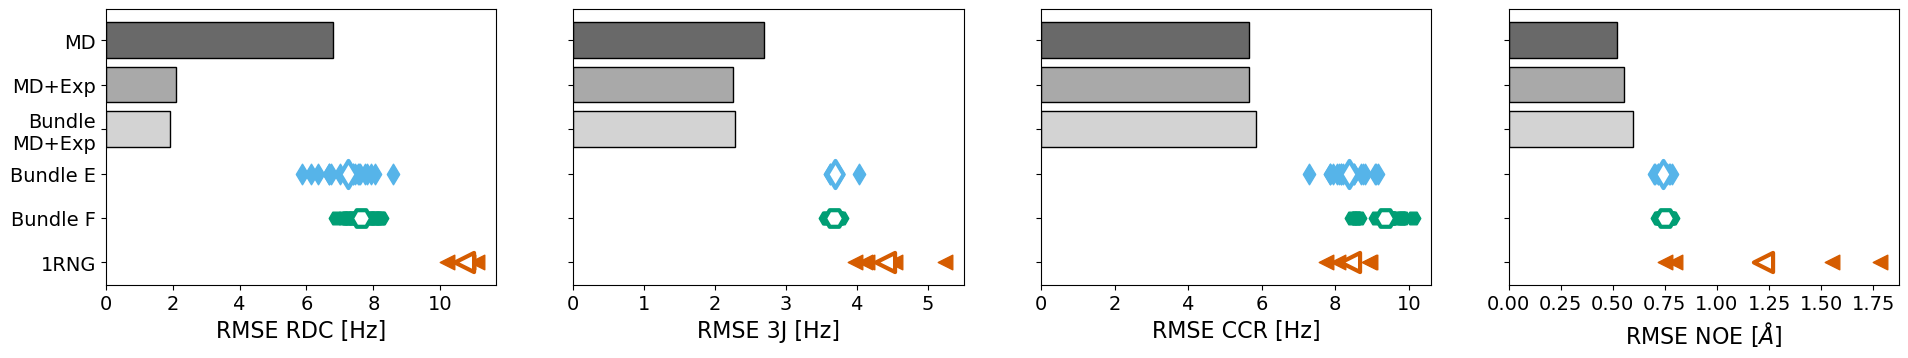

In [49]:
greys = ['dimgrey', 'darkgrey', 'lightgrey']
lbl = ['RDC [Hz]', '3J [Hz]', 'CCR [Hz]', r'NOE [$\AA$]']

plt.subplots(1,4,figsize=[20,4.5], sharey=True)

for i in range(len(lbl)):
    print(f'\n{lbl[i]:}')
    plt.subplot(1,4,i+1)
    for j,k in enumerate(rmse_md.keys()):
        plt.barh(x_lbl[j], rmse_md[k][i], edgecolor='k', color=greys[j], height=0.8)
        print(f'{x_lbl[j]}: {rmse_md[k][i]:.2f}')

    for j,k in enumerate(rmse_bundles.keys()):
        plt.scatter(rmse_bundles[k][i,:], [k for j in range(rmse_bundles[k].shape[-1])], marker=markers[j], color=cc[j], s=msizes[j])#, alpha=0.7)
        plt.scatter(np.average(rmse_bundles[k][i,:]), k, marker=markers[j], edgecolor=cc[j], color='w', s=msizes[j]+80, zorder=10, linewidths=3)
        print(f'{k}: {np.average(rmse_bundles[k][i,:]):.2f}')
    plt.yticks(range(len(x_lbl)), x_lbl, rotation=0, fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel(f'RMSE {lbl[i]}', fontsize=16)
    plt.ylim(-0.7,len(x_lbl)-0.5)    
    plt.gca().invert_yaxis()
plt.tight_layout(pad=4)
# plt.savefig(f'plots/rmse_comp_all_horiz.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig(f'plots/rmse_comp_all_horiz.pdf', facecolor='white', bbox_inches='tight')
plt.show()


# Calculate dihedral angles

In [50]:
angles_bb = ["alpha","beta","gamma","delta","eps","zeta","chi"]

Load and get angles for PDB MD:

In [51]:
traj_f   = f'concat_traj_nopbc.xtc'
top_f    = f'initial_nopbc_mdtraj.pdb'

aa_md,res_md = bb.backbone_angles(traj_f, top_f, residues=['G_5_0', 'C_6_0', 'U_7_0', 'U_8_0', 'G_9_0', 'C_10_0'], angles=angles_bb)
aa_md *= 180.0/np.pi
print(aa_md.shape)

# Loading concat_traj_nopbc.xtc 


(20100, 6, 7)


Load and get angles for bundles and 1RNG:

In [52]:
aa_bundles = {}
for f in bundles:
    aa_bundles[f] = get_angles_bundle(f'/storage1/kummerer/TETRALOOPS/CUUG/exp_data/paper_bundles/Bundle_{f}_gmx.pdb', angles_bb)*180.0/np.pi

# Loading /storage1/kummerer/TETRALOOPS/CUUG/exp_data/paper_bundles/Bundle_E_gmx.pdb 


(20, 6, 7)


# Loading /storage1/kummerer/TETRALOOPS/CUUG/exp_data/paper_bundles/Bundle_F_gmx.pdb 


(20, 6, 7)
(5, 6, 7)


# Loading /storage1/kummerer/TETRALOOPS/CUUG/exp_data/paper_bundles/Bundle_1RNG_gmx.pdb 


## Dihedrals from cluster 0 and 2

In [53]:
qt_labels = np.loadtxt(f'qt_clustering/QT_Clusters.txt')

cluster_members = {}
for i in set(qt_labels):
    cluster_members[int(i)] = np.where(qt_labels==i)[0]

In [54]:
cluster_members

{0: array([ 1,  4,  6,  9, 11, 16, 18, 26, 28, 32, 33, 37, 38, 40, 48, 51, 52,
        55, 59, 64, 71, 73, 76, 77, 78, 86, 87, 89]),
 1: array([ 0,  7, 13, 20, 23, 27, 30, 34, 39, 41, 53, 54, 57, 65, 68, 74, 75,
        83, 90, 95]),
 2: array([ 8, 35, 66, 70, 85, 94]),
 -1: array([ 2,  3,  5, 10, 12, 14, 15, 17, 19, 21, 22, 24, 25, 29, 31, 36, 42,
        43, 44, 45, 46, 47, 49, 50, 56, 58, 60, 61, 62, 63, 67, 69, 72, 79,
        80, 81, 82, 84, 88, 91, 92, 93, 96, 97, 98, 99])}

## G9 $\chi$ angle

# Plot angle & CCR/3J

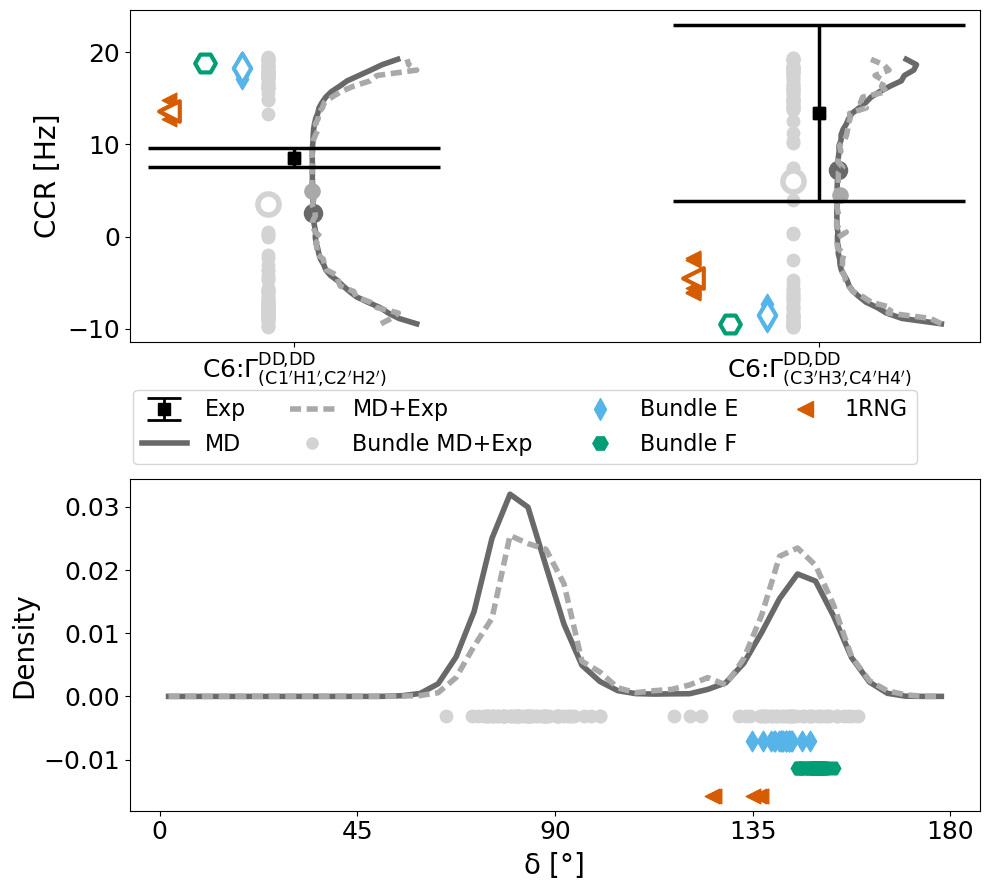

In [59]:
plot_angle_measurement('C6', 'delta', ['C1-C2', 'C3-C4'], 'ccr', save=True)

# Plot G5/C6 RMSE and C2'-endo population

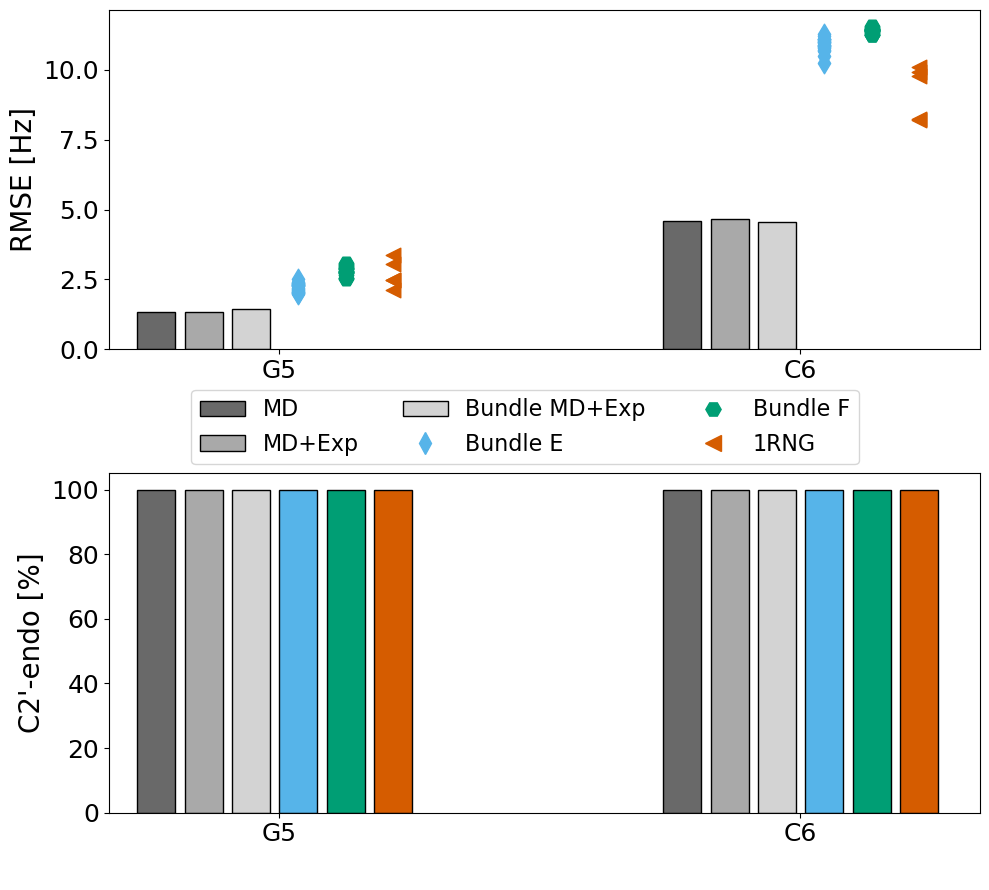

In [60]:
fig, ax = plt.subplots(2,1, figsize=[10,9])
###### UPPER PANEL ######
for i,idx in enumerate(['G5', 'C6']):
    idxs = [get_measurement_idx(ccr_lbl, j.split(':')[0], j.split(':')[-1]) for j in [f'{idx}:C1-C2', f'{idx}:C3-C4']]
    idxs = [get_measurement_idx(ccr_lbl, j.split(':')[0], j.split(':')[-1]) for j in [f'{idx}:C1-C2', f'{idx}:C3-C4']]
    idxss = [get_measurement_idx(j3_lbl, j.split(':')[0], j.split(':')[-1]) for j in j3_lbl if ('H1H2' in j or 'H2H3' in j or 'H3H4' in j) and f'{idx}' in j ]
    rmses = []
    rmses.append(calc_RMSE_ensemble(np.concatenate((ccr_exp[idxs,:],j3_exp[idxss,:])), np.hstack((ccr_calc[:,idxs],j3_calc[:,idxss])), w0))
    rmses.append(calc_RMSE_ensemble(np.concatenate((ccr_exp[idxs,:],j3_exp[idxss,:])), np.hstack((ccr_calc[:,idxs],j3_calc[:,idxss])), w_rew))
    rmses.append(calc_RMSE_ensemble(np.concatenate((ccr_exp[idxs,:],j3_exp[idxss,:])), np.hstack((ccr_calc[:,idxs],j3_calc[:,idxss]))[frames,:], np.array([1/100]*100)))
    for f in bundles:
        rmses.append(calc_RMSE_bundle(np.concatenate((ccr_exp[idxs,:],j3_exp[[3,5,10],:])), np.hstack((ccr_bundles[f][:,idxs],j3_bundles[f][:,idxss]))))

    
    ax[0].bar(0.1+i/1.8, rmses[0], color='dimgrey', edgecolor='k', width=0.04)
    ax[0].bar(0.15+i/1.8, rmses[1], color='darkgrey', edgecolor='k', width=0.04)
    ax[0].bar(0.2+i/1.8, rmses[2], color='lightgrey', edgecolor='k', width=0.04)
    
    for j in range(3,6):
         ax[0].scatter([0.1+(0.05*j)+i/1.8]*len(rmses[j]), rmses[j], s=msizes[j-3], marker=markers[j-3], color=cc[j-3])

    ax[0].set_xlim(0.05,.97)
    ax[0].set_xticks([0.23,0.78])
    ax[0].set_xticklabels([m for m in ['G5', 'C6']])        
    ax[0].tick_params(axis='both', which='major', labelsize=18)
    ax[0].set_ylabel('RMSE [Hz]', fontsize=20)

###### LOWER PANEL ######    
for i,idx in enumerate(['G5', 'C6']):
    tmp = aa_md[:,int(idx[1:])-5,angles_bb.index('delta')]
    ax[1].bar(0.1+i/1.8, sum([1 if i>2.0 else 0 for i in tmp]*w0)*100, color='dimgrey', edgecolor='k', width=0.04)
    ax[1].bar(0.15+i/1.8, sum([1 if i>2.0 else 0 for i in tmp]*w_rew)*100, color='darkgrey', edgecolor='k', width=0.04)
    ax[1].bar(0.2+i/1.8, sum([1 if i>2.0 else 0 for i in tmp[frames]]*w0_100)*100, color='lightgrey', edgecolor='k', width=0.04)

    for j,jj in enumerate(bundles):
        tmp = aa_bundles[jj][:,int(idx[1:])-5,angles_bb.index('delta')]
        ax[1].bar(0.25+i/1.8+j*0.05, 100*len(np.where(tmp>2.0)[0])/len(tmp), color=cc[j], edgecolor='k', width=0.04)
        if 100*len(np.where(tmp>2.0)[0])/len(tmp) == 0:
            ax[1].text(0.1+(0.05*(j+3))+i/1.8, 2, '*', color=cc[j], fontsize=22, fontweight='heavy')
    
    ax[1].set_xlim(0.05,.97)
    ax[1].set_xticks([0.23,0.78])
    ax[1].set_xticklabels([m for m in ['G5', 'C6']])        
    ax[1].tick_params(axis='both', which='major', labelsize=18)
    ax[1].set_ylabel("C2'-endo [%]", fontsize=20)
    ax[1].set_xlabel(r' ', fontsize=20)

    
# Custom legend:
handles1 =  [Patch(facecolor='dimgrey', edgecolor='k', label='MD'),
             Patch(facecolor='darkgrey', edgecolor='k', label='MD+Exp'),
             Patch(facecolor='lightgrey', edgecolor='k', label='Bundle MD+Exp')]
handles2 =  [Line2D([0], [0], lw=4, ls='', color=cc[i], marker=markers[i], markersize=msizes[i]/10, label=ii) for i,ii in enumerate(['Bundle E', 'Bundle F', '1RNG']) ]
fig.legend(handles=[item for sublist in [handles1, handles2] for item in sublist], fontsize=16, ncol=3, loc='center', bbox_to_anchor=(0.53, 0.52), fancybox=True) #, edgecolor='k'

plt.tight_layout(h_pad=6.5)
plt.savefig('plots/G5_C6_RMSE_c2endo.pdf')
# plt.savefig('plots/G5_C6_RMSE_c2endo.png', dpi=300)
plt.show()

# Plot C6-G9 bp, U8-G9 outward stacking, U8-G9 upward stacking

In [61]:
def get_pairing(pairings, pair_idx): # pair_idx = [0,13]
    bp = []
    bp_labels = []
    for p in pairings:
        if pair_idx in p[0]: # Check for bp
    #         bp_c5_g10.append(p[1][p[0].index([4,9])]) # Use if collecting the bps only
            if p[1][p[0].index(pair_idx)][:2] == 'WC' or p[1][p[0].index(pair_idx)][:2] == 'WW':
                bp.append(0)
                bp_labels.append('WW/WC')
            elif p[1][p[0].index(pair_idx)][:2] == 'XX':
                bp.append(2)
                bp_labels.append('None') #bp_labels.append('XX')
            else:
                bp.append(1)
                bp_labels.append('non-WW/WC')
        else:
            bp.append(0)
            bp_labels.append('None')
    return np.array(bp), bp_labels

In [62]:
def get_stacking(stackings, pair_idx, stack_type):
    st = []
    st_labels = []
    for s in stackings:
        if pair_idx in s[0]:
            if s[1][s[0].index(pair_idx)] == stack_type:
                st.append(1)
                st_labels.append(stack_type)
            else:
                st.append(0)
                st_labels.append('None')
        else:
            st.append(0)
            st_labels.append('None')
            
    return st#, st_label

In [63]:
traj_f   = f'concat_traj_nopbc.xtc'
top_f    = f'initial_nopbc_mdtraj.pdb'

stackings,pairings,residues = bb.annotate(traj_f,topology=top_f)

# Loading concat_traj_nopbc.xtc 


In [65]:
stacks_bundles, pairs_bundles, res_bundles = {}, {}, {}
for f in bundles:
    stacks_bundles[f], pairs_bundles[f], res_bundles[f] = bb.annotate(f'nmrbundle_data/Bundle_{f}_gmx.pdb')

# Loading nmrbundle_data/Bundle_E_gmx.pdb 
# Loading nmrbundle_data/Bundle_F_gmx.pdb 
# Loading nmrbundle_data/Bundle_1RNG_gmx.pdb 


In [67]:
_,c6_g9_md = get_pairing(pairings, pair_idx=[residues.index('C_6_0'), residues.index('G_9_0')])
_,c6_g9_md = get_pairing(pairs_bundles['E'], pair_idx=[ res_bundles['E'].index('C_6_0'), res_bundles['E'].index('G_9_0')])

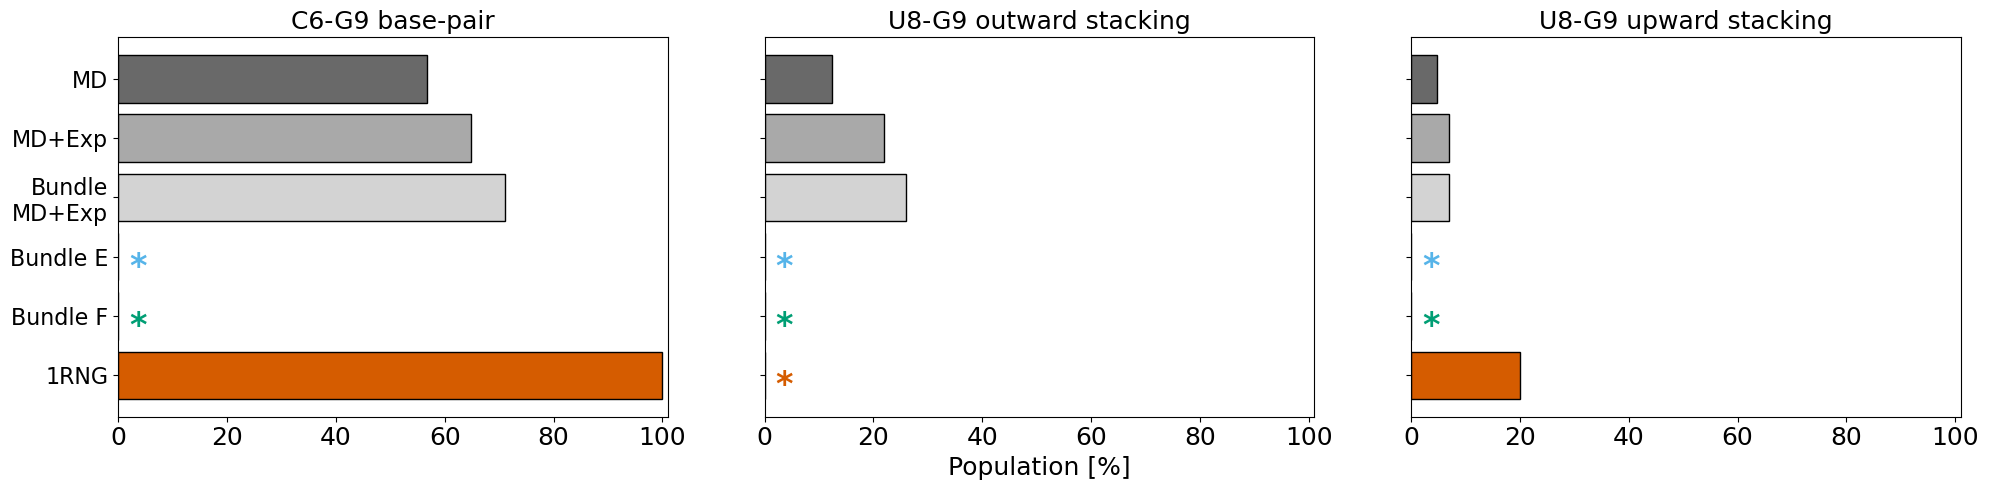

In [68]:
fig, ax = plt.subplots(1,3, figsize=[20,5], sharey=True)

######## LEFT PANEL ########
_,c6_g9_md = get_pairing(pairings, pair_idx=[residues.index('C_6_0'), residues.index('G_9_0')])
ax[0].barh(5,100*sum([sum([1 if i == k else 0 for i in c6_g9_md]*w0) for k in ['WW/WC', 'non-WW/WC']]),fc='dimgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)
ax[0].barh(4,100*sum([sum([1 if i == k else 0 for i in c6_g9_md]*w_rew) for k in ['WW/WC', 'non-WW/WC']]),fc='darkgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)
ax[0].barh(3,100*sum([sum([1 if i == k else 0 for i in np.array(c6_g9_md)[frames]]*np.full(len(frames), 1/len(frames))) for k in ['WW/WC', 'non-WW/WC']]),fc='lightgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)

for ff,f in enumerate(bundles):
    _,c6_g9_md = get_pairing(pairs_bundles[f], pair_idx=[ res_bundles[f].index('C_6_0'), res_bundles[f].index('G_9_0')])
    ax[0].barh(2-ff,100*sum([np.average([1 if i == k else 0 for i in c6_g9_md]) for k in ['WW/WC', 'non-WW/WC']]),fc=cc[ff], height=0.8, ec='k')#,label=tnames[i],alpha=0.7)
    if 100*sum([np.average([1 if i == k else 0 for i in c6_g9_md]) for k in ['WW/WC', 'non-WW/WC']]) == 0:
        ax[0].text(2, 2-ff-0.34, '*', color=cc[ff], fontsize=24, fontweight='heavy')

ax[0].set_xlim(0, 101)
ax[0].set_ylim(-0.7,6.7)
ax[0].set_yticks(np.arange(6))
ax[0].set_yticklabels(reversed(['MD', 'MD+Exp', 'Bundle MD+Exp', 'Bundle E', 'Bundle F', '1RNG']), fontsize=16)
ax[0].tick_params(axis='x', which='major', labelsize=18)
ax[0].set_title('C6-G9 base-pair', fontsize=18)


######## MIDDLE PANEL ########
ax[1].barh(5,100*sum(get_stacking(stackings, [residues.index('U_8_0'), residues.index('G_9_0')], '<>')*w0),fc='dimgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)
ax[1].barh(4,100*sum(get_stacking(stackings, [residues.index('U_8_0'), residues.index('G_9_0')], '<>')*w_rew),fc='darkgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)
ax[1].barh(3,100*sum(np.array(get_stacking(stackings, [residues.index('U_8_0'), residues.index('G_9_0')], '<>'))[frames])/len(frames), fc='lightgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)

for ff,f in enumerate(bundles):
    # _,c6_g9_md = get_pairing(pairs_bundles[f], pair_idx=[ res_bundles[f].index('C_6_0'), res_bundles[f].index('G_9_0')])
    ax[1].barh(2-ff,100*sum(get_stacking(stacks_bundles[f], [res_bundles[f].index('U_8_0'), res_bundles[f].index('G_9_0')], '<>'))/len(stacks_bundles[f]), fc=cc[ff], ec='k', height=0.8)#,label=tnames[i],alpha=0.7)
    if sum(get_stacking(stacks_bundles[f], [res_bundles[f].index('U_8_0'), res_bundles[f].index('G_9_0')], '<>')) == 0:
        ax[1].text(2, 2-ff-0.34, '*', color=cc[ff], fontsize=24, fontweight='heavy')

        ax[1].set_ylim(-0.7,6.7)
        
ax[1].set_xlim(0, 101)
ax[1].set_yticks(np.arange(6))
ax[1].set_yticklabels(reversed(['MD', 'MD+Exp', 'Bundle MD+Exp', 'Bundle E', 'Bundle F', '1RNG']), fontsize=16)
ax[1].tick_params(axis='x', which='major', labelsize=18)
ax[1].set_title('U8-G9 outward stacking', fontsize=18)
ax[1].set_xlabel('Population [%]', fontsize=18)


######## RIGHT PANEL ########
ax[2].barh(5,100*sum(get_stacking(stackings, [residues.index('U_8_0'), residues.index('G_9_0')], '>>')*w0),fc='dimgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)
ax[2].barh(4,100*sum(get_stacking(stackings, [residues.index('U_8_0'), residues.index('G_9_0')], '>>')*w_rew),fc='darkgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)
ax[2].barh(3,100*sum(np.array(get_stacking(stackings, [residues.index('U_8_0'), residues.index('G_9_0')], '>>'))[frames])/len(frames), fc='lightgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)

for ff,f in enumerate(bundles):
    # _,c6_g9_md = get_pairing(pairs_bundles[f], pair_idx=[ res_bundles[f].index('C_6_0'), res_bundles[f].index('G_9_0')])
    ax[2].barh(2-ff,100*sum(get_stacking(stacks_bundles[f], [res_bundles[f].index('U_8_0'), res_bundles[f].index('G_9_0')], '>>'))/len(stacks_bundles[f]), fc=cc[ff], ec='k', height=0.8)#,label=tnames[i],alpha=0.7)
    if sum(get_stacking(stacks_bundles[f], [res_bundles[f].index('U_8_0'), res_bundles[f].index('G_9_0')], '>>')) == 0:
        ax[2].text(2, 2-ff-0.34, '*', color=cc[ff], fontsize=24, fontweight='heavy')

        ax[2].set_ylim(-0.7,5.7)

ax[2].set_xlim(0, 101)
ax[2].set_yticks(np.arange(6))
ax[2].set_yticklabels(reversed(['MD', 'MD+Exp', 'Bundle\nMD+Exp', 'Bundle E', 'Bundle F', '1RNG']), fontsize=16)
ax[2].tick_params(axis='x', which='major', labelsize=18)
ax[2].set_title('U8-G9 upward stacking', fontsize=18)


plt.tight_layout(w_pad=5)
plt.savefig('plots/c6g9bp_u8g9_stacking.pdf')
# plt.savefig('plots/c6g9bp_u8g9_stacking.png', dpi=300)
plt.show()

# SI Fig: G5-C10 bp and RMSE with and without G5-C10 bp

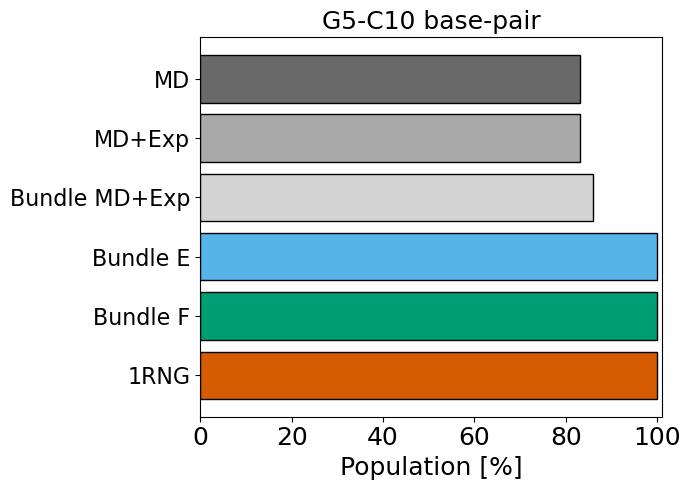

In [69]:
fig, ax = plt.subplots(1,1, figsize=[7,5], sharey=True)

######## LEFT PANEL ########
_,g5_c10_md = get_pairing(pairings, pair_idx=[residues.index('G_5_0'), residues.index('C_10_0')])
ax.barh(5,100*sum([sum([1 if i == k else 0 for i in g5_c10_md]*w0) for k in ['WW/WC', 'non-WW/WC']]),fc='dimgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)
ax.barh(4,100*sum([sum([1 if i == k else 0 for i in g5_c10_md]*w_rew) for k in ['WW/WC', 'non-WW/WC']]),fc='darkgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)
ax.barh(3,100*sum([sum([1 if i == k else 0 for i in np.array(g5_c10_md)[frames]]*np.full(len(frames), 1/len(frames))) for k in ['WW/WC', 'non-WW/WC']]),fc='lightgrey', ec='k', height=0.8)#,label=tnames[i],alpha=0.7)

for ff,f in enumerate(bundles):
    _,g5_c10_md = get_pairing(pairs_bundles[f], pair_idx=[ res_bundles[f].index('G_5_0'), res_bundles[f].index('C_10_0')])
    ax.barh(2-ff,100*sum([np.average([1 if i == k else 0 for i in g5_c10_md]) for k in ['WW/WC', 'non-WW/WC']]),fc=cc[ff], height=0.8, ec='k')#,label=tnames[i],alpha=0.7)
    if 100*sum([np.average([1 if i == k else 0 for i in g5_c10_md]) for k in ['WW/WC', 'non-WW/WC']]) == 0:
        ax.text(2, 2-ff-0.34, '*', color=cc[ff], fontsize=24, fontweight='heavy')

ax.set_xlim(0, 101)
ax.set_ylim(-0.7,5.7)
ax.set_yticks(np.arange(6))
ax.set_yticklabels(reversed(['MD', 'MD+Exp', 'Bundle MD+Exp', 'Bundle E', 'Bundle F', '1RNG']), fontsize=16)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.set_title('G5-C10 base-pair', fontsize=18)
ax.set_xlabel('Population [%]', fontsize=18)


plt.tight_layout(w_pad=5)
plt.savefig('plots/g5c10_bp.pdf')
# plt.savefig('plots/g5c10_bp.png', dpi=300)
plt.show()

In [71]:
_,g5_c10_md = get_pairing(pairings, pair_idx=[residues.index('G_5_0'), residues.index('C_10_0')])
g5_c10_md_num = np.array([0 if i=='WW/WC' else 1 if i=='non-WW/WC' else 2 for i in g5_c10_md]) # turn label list into ints: 'WW/WC'=0, 'non-WW/WC'=1, 'none'=2

g5_c10_bp = np.argwhere(g5_c10_md_num[frames]!=2).flatten()
g5_c10_nobp = np.argwhere(g5_c10_md_num[frames]==2).flatten()

print(g5_c10_bp.shape, g5_c10_nobp.shape)

(86,) (14,)


In [72]:
w0_100 = np.array([1/100]*100)
rmse_all = np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[frames,:]*L_calc, w0_100), calc_RMSE_ensemble(j3_exp, j3_calc[frames,:], w0_100), calc_RMSE_ensemble(ccr_exp, ccr_calc[frames,:], w0_100), calc_RMSE_ensemble(noe_exp, noe_calc[frames,:], w0_100, noe=True)])

w0_100 = np.array([1/len(g5_c10_bp)]*len(g5_c10_bp))
rmse_bp = np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[frames,:][g5_c10_bp,:]*L_calc, w0_100), calc_RMSE_ensemble(j3_exp, j3_calc[frames,:][g5_c10_bp,:], w0_100), calc_RMSE_ensemble(ccr_exp, ccr_calc[frames,:][g5_c10_bp,:], w0_100), calc_RMSE_ensemble(noe_exp, noe_calc[frames,:][g5_c10_bp,:], w0_100, noe=True)])

w0_100 = np.array([1/len(g5_c10_nobp)]*len(g5_c10_nobp))
rmse_nobp = np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[frames,:][g5_c10_nobp,:]*L_calc, w0_100), calc_RMSE_ensemble(j3_exp, j3_calc[frames,:][g5_c10_nobp,:], w0_100), calc_RMSE_ensemble(ccr_exp, ccr_calc[frames,:][g5_c10_nobp,:], w0_100), calc_RMSE_ensemble(noe_exp, noe_calc[frames,:][g5_c10_nobp,:], w0_100, noe=True)])

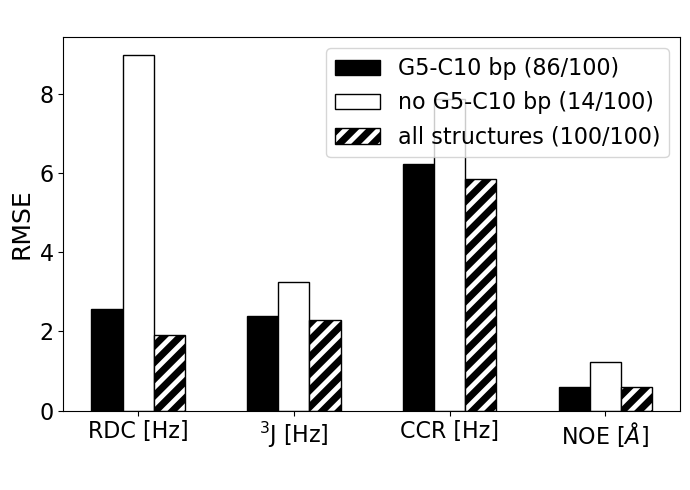

In [73]:
lbl = [r'RDC [Hz]', r'$^3$J [Hz]', r'CCR [Hz]', r'NOE [$\AA$]']
width = 0.2
x = np.arange(4)
plt.figure(figsize=[7,5])


plt.bar(x-0.2, rmse_bp, width=width, facecolor='k', edgecolor='k', label='G5-C10 bp (86/100)')
plt.bar(x,     rmse_nobp, width=width, facecolor='w', edgecolor='k', label='no G5-C10 bp (14/100)')
plt.bar(x+0.2, rmse_all, width=width, facecolor='w', edgecolor='k', hatch='//', label='all structures (100/100)')

plt.xticks(x, lbl, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('RMSE', fontsize=18)
plt.legend(fontsize=16)
plt.title(' ', fontsize=18)
plt.xlabel(' ', fontsize=18)

plt.tight_layout()
plt.savefig('plots/rmse_bundle_g5c10_bp.pdf')
# plt.savefig('plots/rmse_bundle_g5c10_bp.png', dpi=300)
plt.show()

# SI Fig: C6-G9 RMSE with and without C6-G9 bp

In [74]:
_,c6_g9_md = get_pairing(pairings, pair_idx=[residues.index('C_6_0'), residues.index('G_9_0')])
c6_g9_md_num = np.array([0 if i=='WW/WC' else 1 if i=='non-WW/WC' else 2 for i in c6_g9_md]) # turn label list into ints: 'WW/WC'=0, 'non-WW/WC'=1, 'none'=2

c6_g9_bp = np.argwhere(c6_g9_md_num[frames]!=2).flatten()
c6_g9_nobp = np.argwhere(c6_g9_md_num[frames]==2).flatten()

print(c6_g9_bp.shape, c6_g9_nobp.shape)

(71,) (29,)


In [75]:
w0_100_ = np.array([1/100]*100)
rmse_all_ = np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[frames,:]*L_calc, w0_100_), calc_RMSE_ensemble(j3_exp, j3_calc[frames,:], w0_100_), calc_RMSE_ensemble(ccr_exp, ccr_calc[frames,:], w0_100_), calc_RMSE_ensemble(noe_exp, noe_calc[frames,:], w0_100_, noe=True)])

w0_100_ = np.array([1/len(c6_g9_bp)]*len(c6_g9_bp))
rmse_bp_ = np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[frames,:][c6_g9_bp,:]*L_calc, w0_100_), calc_RMSE_ensemble(j3_exp, j3_calc[frames,:][c6_g9_bp,:], w0_100_), calc_RMSE_ensemble(ccr_exp, ccr_calc[frames,:][c6_g9_bp,:], w0_100_), calc_RMSE_ensemble(noe_exp, noe_calc[frames,:][c6_g9_bp,:], w0_100_, noe=True)])

w0_100_ = np.array([1/len(c6_g9_nobp)]*len(c6_g9_nobp))
rmse_nobp_ = np.array([calc_RMSE_ensemble(rdc_exp, rdc_calc[frames,:][c6_g9_nobp,:]*L_calc, w0_100_), calc_RMSE_ensemble(j3_exp, j3_calc[frames,:][c6_g9_nobp,:], w0_100_), calc_RMSE_ensemble(ccr_exp, ccr_calc[frames,:][c6_g9_nobp,:], w0_100_), calc_RMSE_ensemble(noe_exp, noe_calc[frames,:][c6_g9_nobp,:], w0_100_, noe=True)])

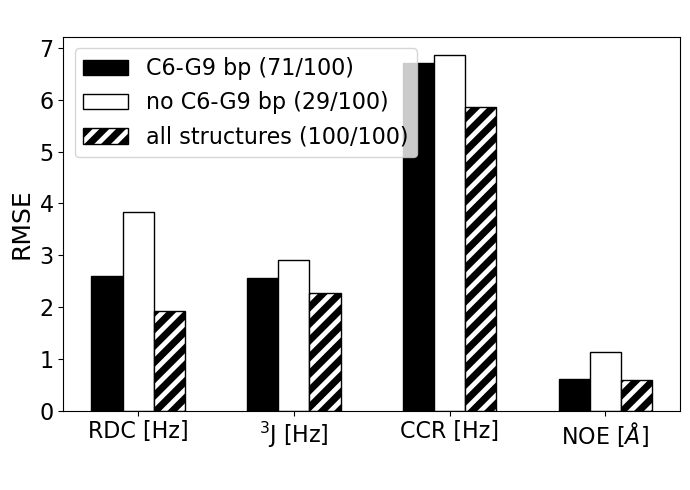

In [281]:
lbl = [r'RDC [Hz]', r'$^3$J [Hz]', r'CCR [Hz]', r'NOE [$\AA$]']
width = 0.2
x = np.arange(4)
plt.figure(figsize=[7,5])


plt.bar(x-0.2, rmse_bp_, width=width, facecolor='k', edgecolor='k', label='C6-G9 bp (71/100)')
plt.bar(x,     rmse_nobp_, width=width, facecolor='w', edgecolor='k', label='no C6-G9 bp (29/100)')
plt.bar(x+0.2, rmse_all_, width=width, facecolor='w', edgecolor='k', hatch='//', label='all structures (100/100)')

plt.xticks(x, lbl, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('RMSE', fontsize=18)
plt.legend(fontsize=16)
plt.title(' ', fontsize=18)
plt.xlabel(' ', fontsize=18)

plt.tight_layout()
plt.savefig('analysis/plots/rmse_bundle_c6g9_bp.pdf')
# plt.savefig('analysis/plots/rmse_bundle_c6g9_bp.png', dpi=300)
plt.show()

# SI Fig: CCR/3J + angle

In [76]:
def plot_angle_measurement_si(res, angle, measurements, mtype, save=False): #residue='U7', angle='delta', measurements=['C1-C2', 'C3-C4'], measurement_type='ccr'/'j3'
    # markers = ['d', 'H', '<', '>']
    # msizes = [110, 110, 110, 110] # markersizes
    
    # if(angle=="delta"):
    #     bins=np.linspace(0.5,np.pi,90)
    #     ang_add = 0
    # elif(angle=="alpha" or angle == "beta" or angle == "gamma" or angle == "zeta" or angle == "eps"):
    #     # tors[np.where(tors<0)] += 2*np.pi
    #     ang_add = 2*np.pi
    #     bins=np.linspace(0,2*np.pi,90)
    # else:
    #     bins=np.linspace(-np.pi,np.pi,90)
    
    if(angle=="delta"):
        bins=np.linspace(0,180,45)
        # bins=np.linspace(0,360,90)
        ang_add = 0
    elif(angle=="alpha" or angle == "beta" or angle == "gamma" or angle == "zeta" or angle == "eps"):
        # tors[np.where(tors<0)] += 2*np.pi
        ang_add = 360
        bins=np.linspace(0,360,90)
    else:
        bins=np.linspace(-180,180,90)

    idxs, xticks = [],[]
    for m in measurements:
        if mtype == 'ccr':
            # idxs.append(get_measurement_idx(ccr_lbl, res, m))
            data_e, data_c, data_b, data_lbl = ccr_exp, ccr_calc, ccr_bundles, ccr_lbl
            ylbl = 'CCR [Hz]'
        elif mtype == 'j3':
            # idxs.append(get_measurement_idx(j3_lbl, res, m))
            data_e, data_c, data_b, data_lbl = j3_exp, j3_calc, j3_bundles, j3_lbl
            ylbl = r'$\mathregular{^3J}$ [Hz]'
        else:
            print('Check measurement type!')
            break
        if f'{res}:{m}' in data_lbl: 
            idxs.append(get_measurement_idx(data_lbl, res, m))
            # xticks.append(f'{res}:{m}')
            xticks.append(f'{res}:{lbl_dict_[m]}')
        else:
            continue

    fig, ax = plt.subplots(2,1, figsize=[10,9])
    ###### UPPER PANEL ######
    err_ = None
    for i,idx in enumerate(idxs):
        # Exp:
        err_ = ax[0].errorbar(1+i, data_e[idx,0], yerr=data_e[idx,1], c='k', marker='s', ls='', markersize=9, elinewidth=2, capthick=2, capsize=10, zorder=10, label='Exp') # just for the legend
        ax[0].errorbar(1+i, data_e[idx,0], yerr=data_e[idx,1], c='k', marker='s', markersize=9, elinewidth=2.5, capthick=2.5, capsize=80, zorder=10) #capsize=210/len(measurements)
        # MD:
        hh, ee = np.histogram(data_c[:,idx], bins=50, density=True)
        ax[0].plot((hh/hh.max()*0.3)+(1.03+i), 0.5*(ee[1:] + ee[:-1]), c='dimgrey', lw=4, zorder=8)
        ax[0].scatter(np.array((hh/hh.max()*0.3)+(1.03+i))[find_nearest(0.5*(ee[1:] + ee[:-1]), np.average(data_c[:,idx]))], np.average(data_c[:,idx]), marker='o', s=170, edgecolor=None, color='dimgrey', zorder=8.5)
        # MD:
        hh, ee = np.histogram(data_c[:,idx], bins=50, density=True, weights=w_rew)
        ax[0].plot((hh/hh.max()*0.3)+(1.03+i), 0.5*(ee[1:] + ee[:-1]), c='darkgrey', lw=4, ls='--', dashes=(2,1), zorder=9)
        ax[0].scatter(np.array((hh/hh.max()*0.3)+(1.03+i))[find_nearest(0.5*(ee[1:] + ee[:-1]), np.average(data_c[:,idx], weights=w_rew))], np.average(data_c[:,idx], weights=w_rew), marker='o', s=120, edgecolor=None, color='darkgrey',zorder=9.5)
        # MD+Exp bundle:
        ax[0].scatter([0.93+i]*len(frames), data_c[frames,idx], s=80, marker='o', color='lightgrey')#, alpha=0.7)
        ax[0].scatter([0.93+i], np.average(data_c[frames,idx], axis=0), s=230, marker='o', edgecolor='lightgrey', color='w', linewidths=4)
        # NMR Bundles + 1RNG:
        for b,bun in enumerate(bundles):
            ax[0].scatter([0.85+i-(0.08*b)]*len(data_b[bun]), data_b[bun][:,idx], s=msizes[b], marker=markers[b], color=cc[b])#, alpha=0.7)
            ax[0].scatter([0.85+i-(0.08*b)], np.average(data_b[bun][:,idx], axis=0), s=msizes[b]+110, marker=markers[b], edgecolor=cc[b], color='w', linewidths=3)

    ax[0].set_xlim(0.6,3.4)
    ax[0].set_xticks(np.arange(1, len(xticks)+1))
    ax[0].set_xticklabels(xticks)        
    ax[0].tick_params(axis='both', which='major', labelsize=18)
    ax[0].set_ylabel(ylbl, fontsize=20)
    ###### LOWER PANEL ######
    # MD:
    # tors[np.where(tors<0)] += 2*np.pi
    aa = aa_md[:,int(res[1:])-5,angles_bb.index(angle)]
    aa[np.where(aa<0)] += ang_add
    hh,ee = np.histogram(aa, bins=bins, density=True, weights=w0)
    ax[1].plot(0.5*(ee[1:]+ee[:-1]), hh, c='dimgrey', lw=4, label='MD')
    # MD+Exp:
    hh,ee = np.histogram(aa, bins=bins, density=True, weights=w_rew)
    ax[1].plot(0.5*(ee[1:]+ee[:-1]), hh, c='darkgrey', lw=4, ls='--', label='MD', dashes=(2,1))
    # MD+Exp bundle:
    ax[1].scatter(aa[frames], [-0.18/180*np.pi]*len(aa[frames]), s=80, marker='o', color='lightgrey')#, alpha=0.7)
    # NMR bundles and 1RNG:
    for b,bun in enumerate(bundles):
        aa = aa_bundles[bun][:,int(res[1:])-5,angles_bb.index(angle)]
        aa[np.where(aa<0)] += ang_add

        ax[1].scatter(aa, [(-b/5/180*np.pi)-0.4/180*np.pi]*len(aa), s=msizes[b], marker=markers[b], color=cc[b])#, alpha=0.7)

    ax[1].set_xticks(np.arange(0,bins.max()+1,bins.max()/4))
    # ax[1].set_xticklabels(xticks)
    ax[1].tick_params(axis='both', which='major', labelsize=18)
    if angle=='eps':
        angle = 'epsilon'
    ax[1].set_xlabel(r'$\mathregular{{s1}}$ [$\degree$] '.replace('s1', '\\'+angle), fontsize=20)
    ax[1].set_ylabel('Density', fontsize=20)
    # Custom legend:
    
    # line = Line2D([],[], ls="none", color='k', marker='s', markersize=9)
    # barline = LineCollection(np.empty((2,2,2)), color='k')
    # err = ErrorbarContainer((line, [line], [barline]), has_xerr=False, has_yerr=True, label='Exp')
    # err = ax.errorbar(x=x,y=y,yerr=yerr,marker='.',ms=10, label='example')

    # ax.legend(handles=[err], labels=["my custom label"], 
          # loc='upper left' ,bbox_to_anchor=(1, 1)  )
    
    handles1 =  [#err,#Line2D([0], [0], lw=4, ls='', color='k', marker='s', label='Exp'),
                 Line2D([0], [0], lw=4, color='dimgrey', label='MD'),
                 Line2D([0], [0], lw=4, ls='--', dashes=(2,1), color='darkgrey', label='MD+Exp'),
                 Line2D([0], [0], lw=4, ls='', color='lightgrey', marker='o', markersize=8, label='Bundle MD+Exp')]
    handles2 =  [Line2D([0], [0], lw=4, ls='', color=cc[i], marker=markers[i], markersize=msizes[i]/10, label=ii) for i,ii in enumerate(['Bundle E', 'Bundle F', '1RNG']) ]
    if err_:
        fig.legend(handles=[item for sublist in [[err_], handles1, handles2] for item in sublist], fontsize=16, ncol=4, loc='center', bbox_to_anchor=(0.53, 0.52), fancybox=True) #, edgecolor='k'
    else:
        fig.legend(handles=[item for sublist in [handles1, handles2] for item in sublist], fontsize=16, ncol=3, loc='center', bbox_to_anchor=(0.53, 0.52), fancybox=True) #, edgecolor='k'

    plt.tight_layout(h_pad=6.5)
    if save == True:
        plt.savefig(f'plots/{res}_{angle}_{mtype}.pdf')
        # plt.savefig(f'plots/{res}_{angle}_{"_".join(measurements)}.png', dpi=300)
    plt.show()
    return err_

## $\alpha$

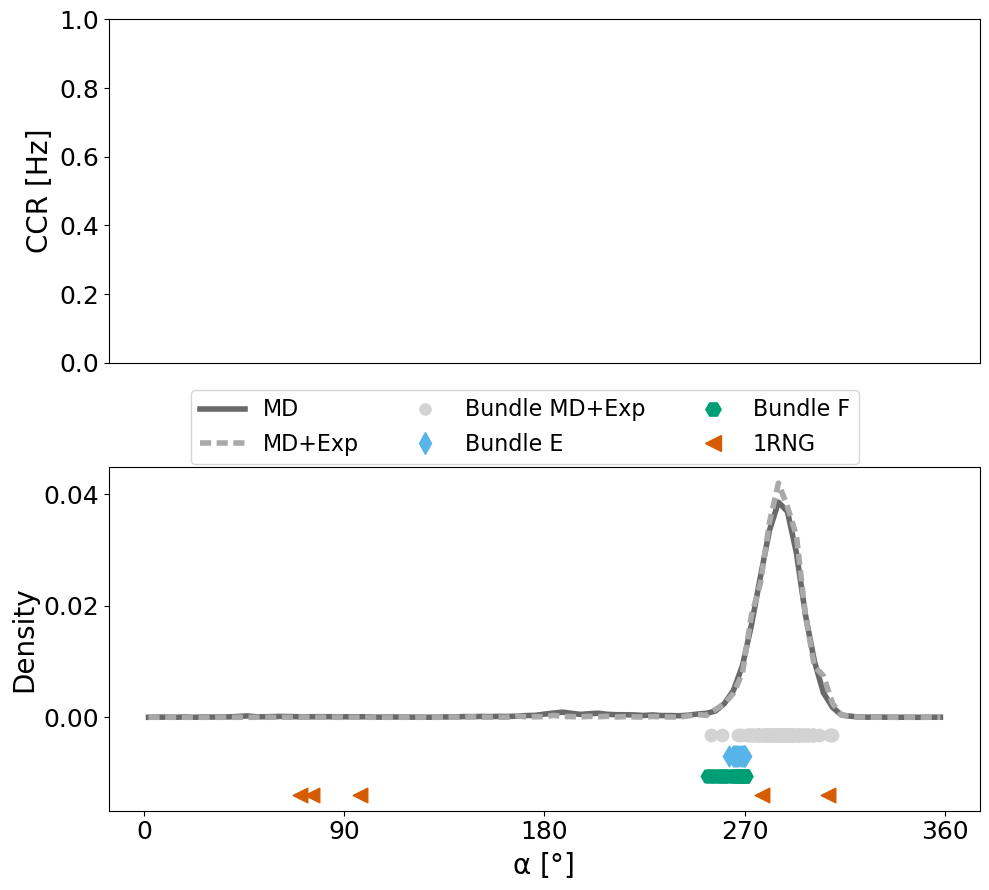

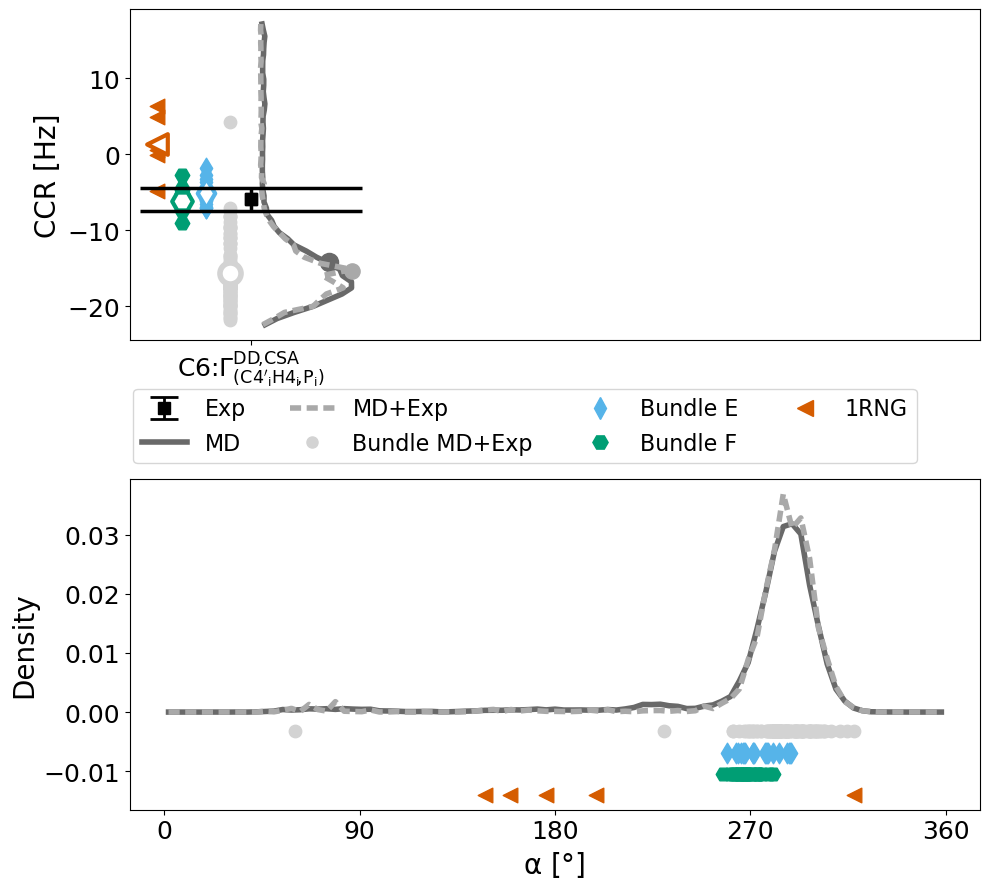

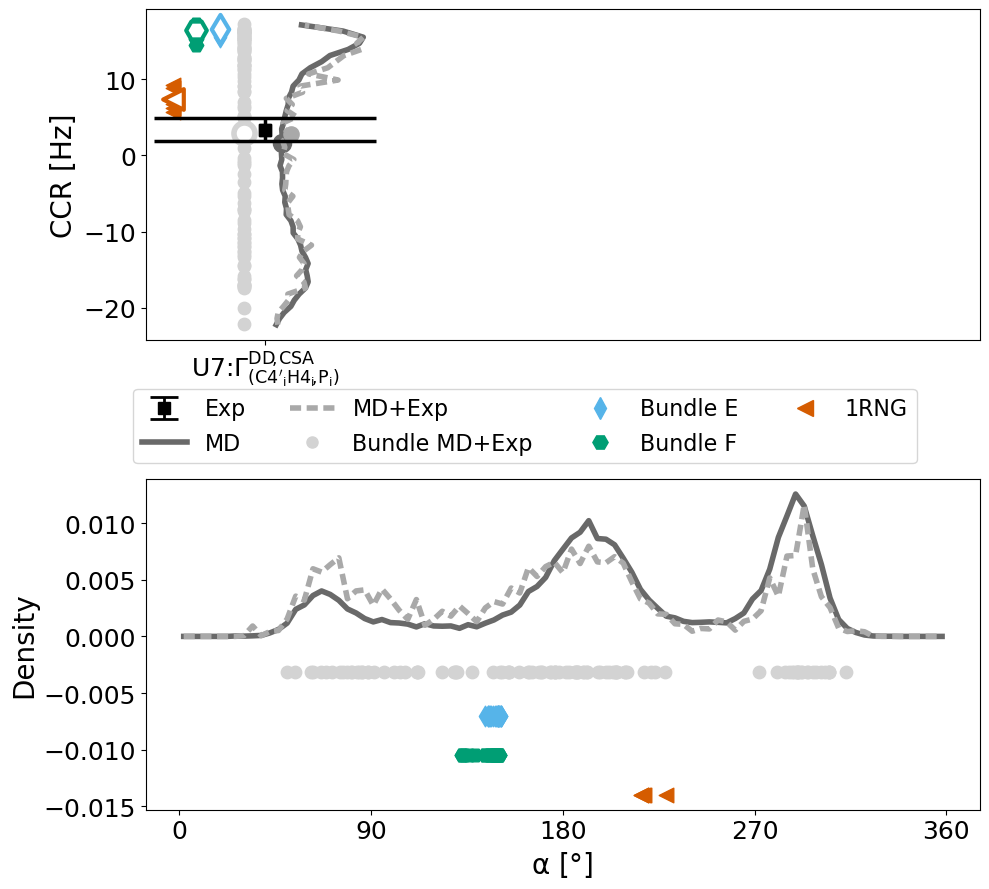

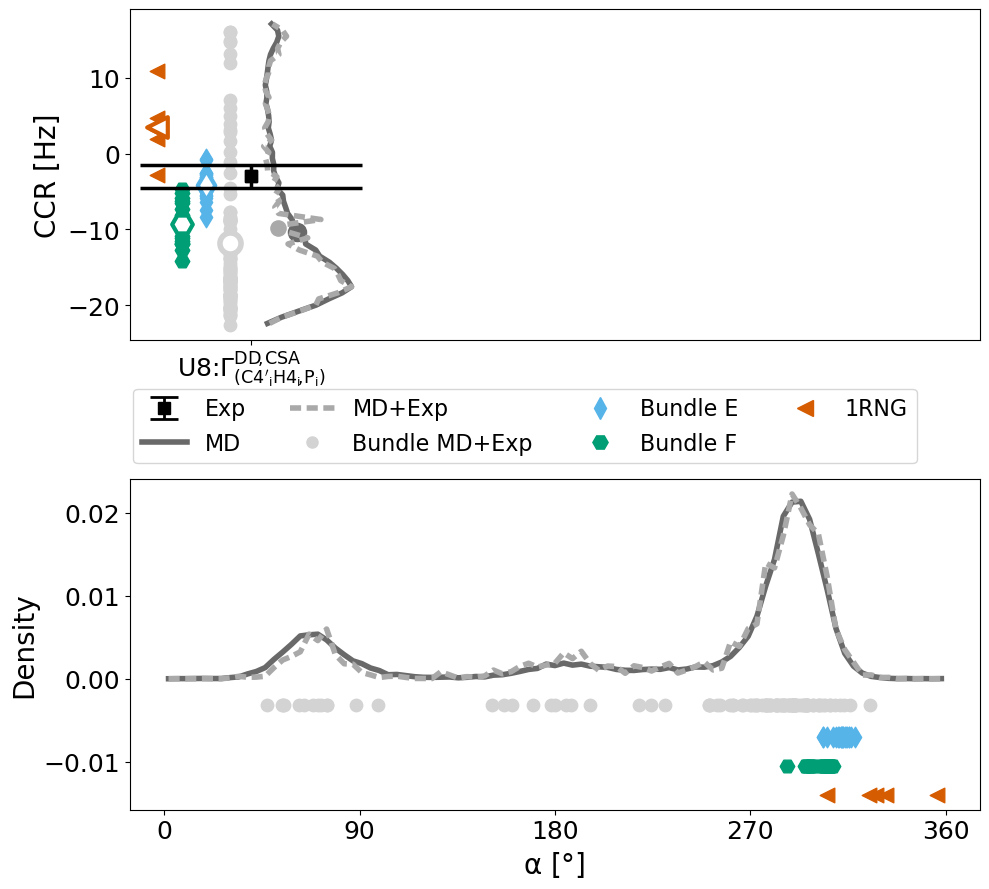

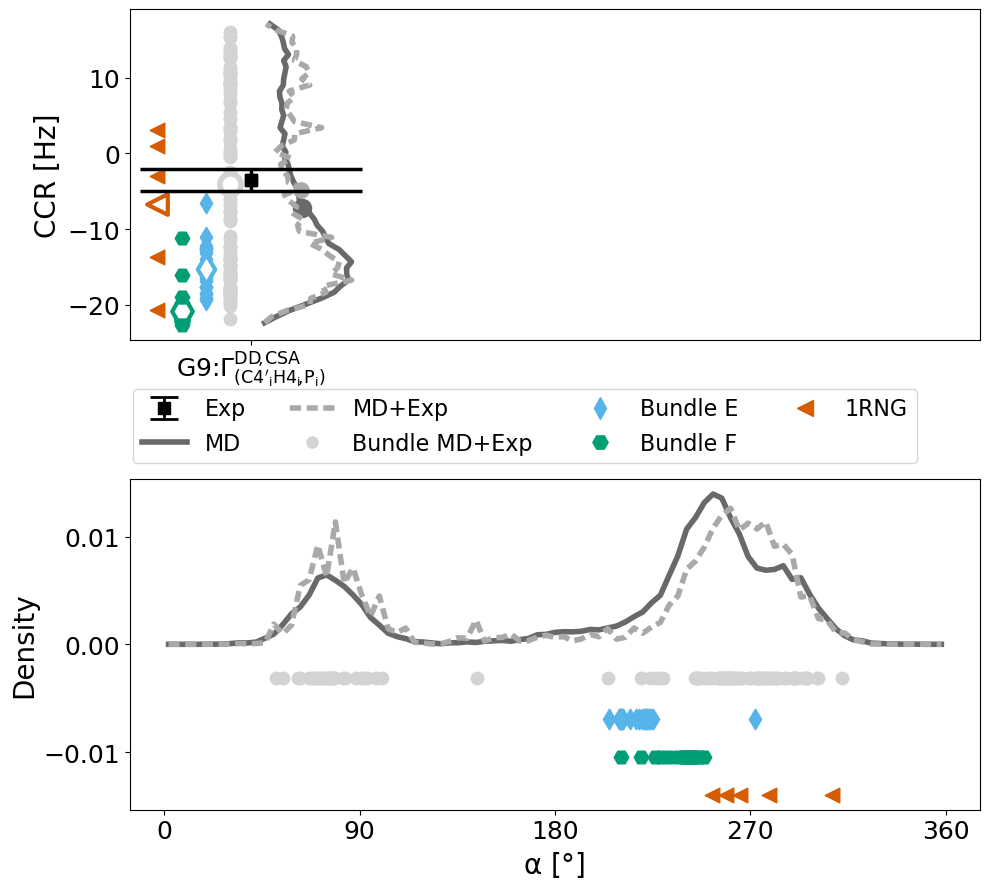

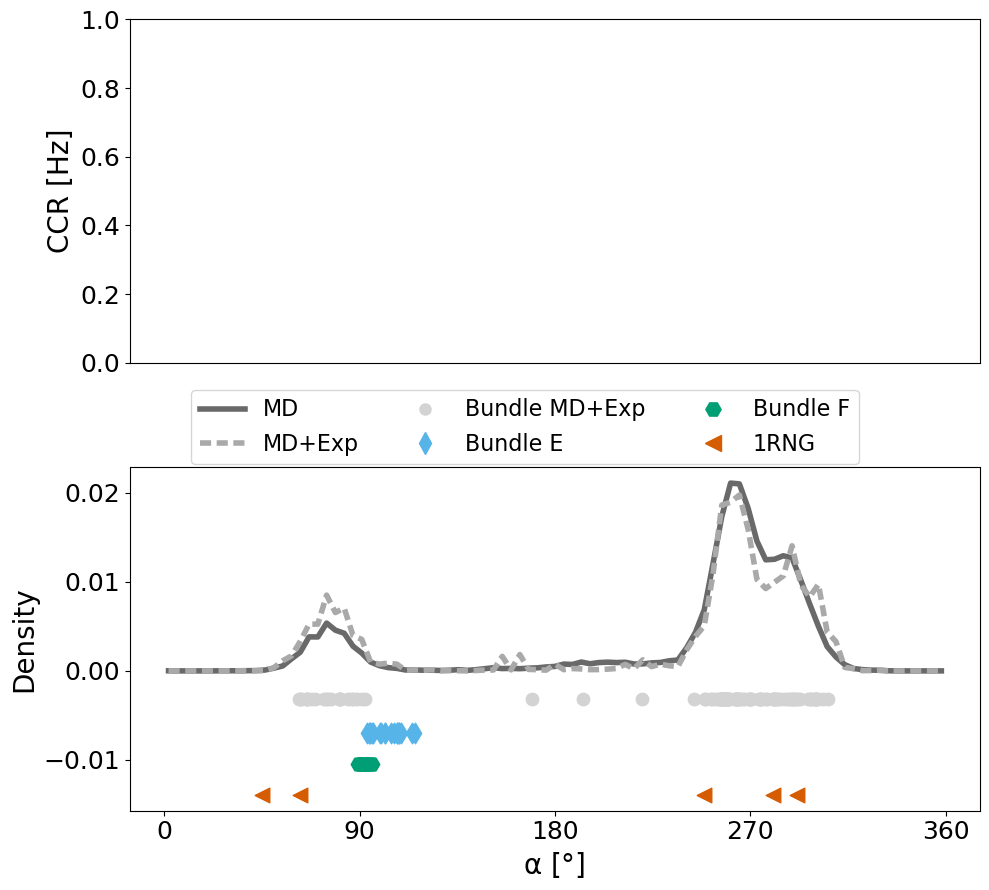

In [77]:
for i,r in enumerate(['G5','C6', 'U7', 'U8', 'G9','C10']):
    plot_angle_measurement_si(r, 'alpha', ['C4p-P'], 'ccr', save=True)

## $\beta$

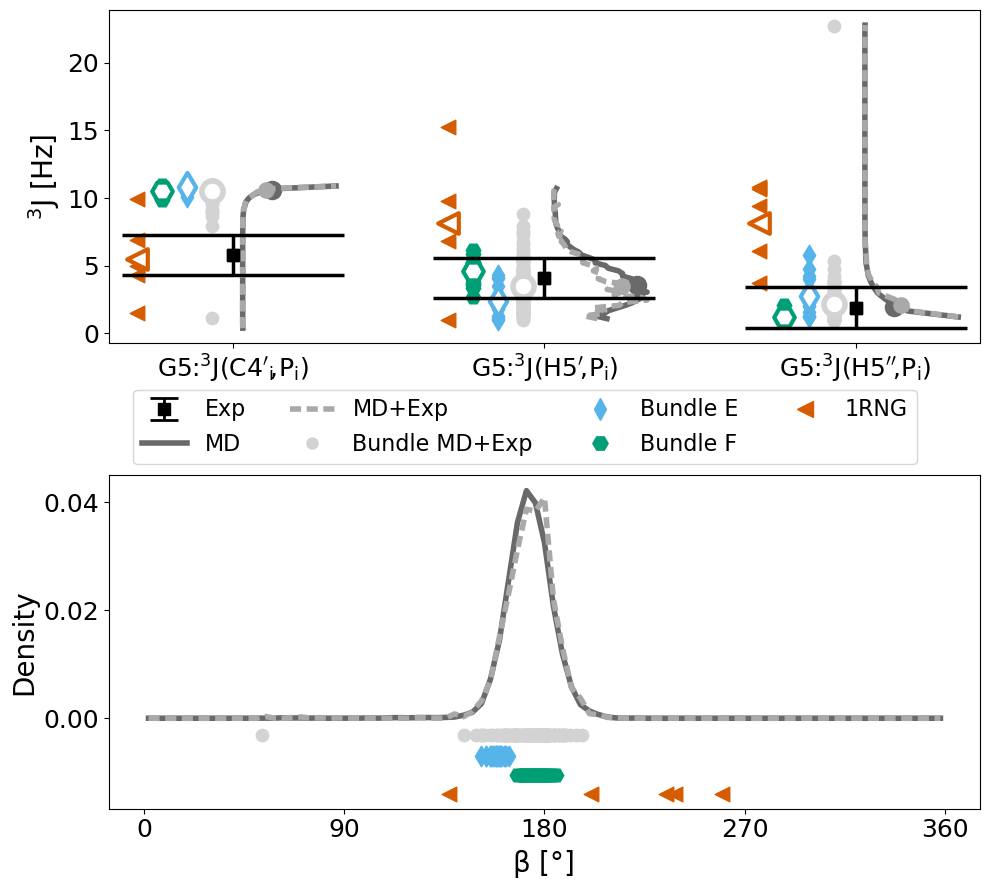

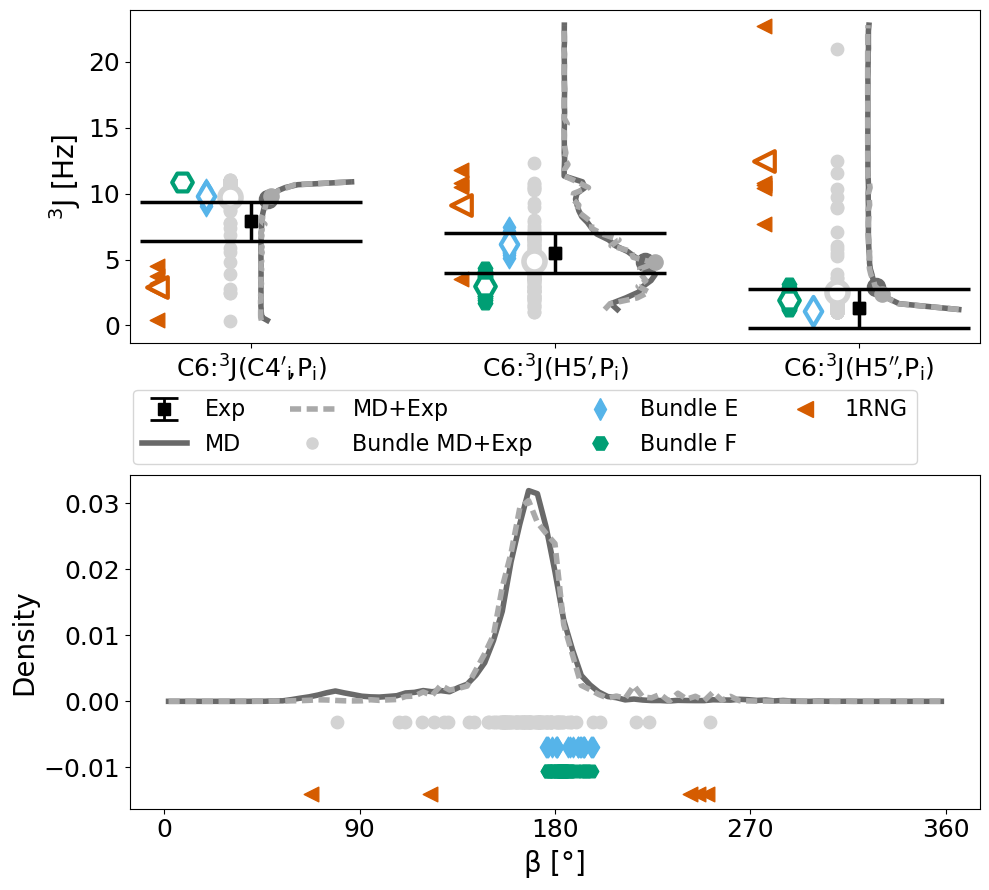

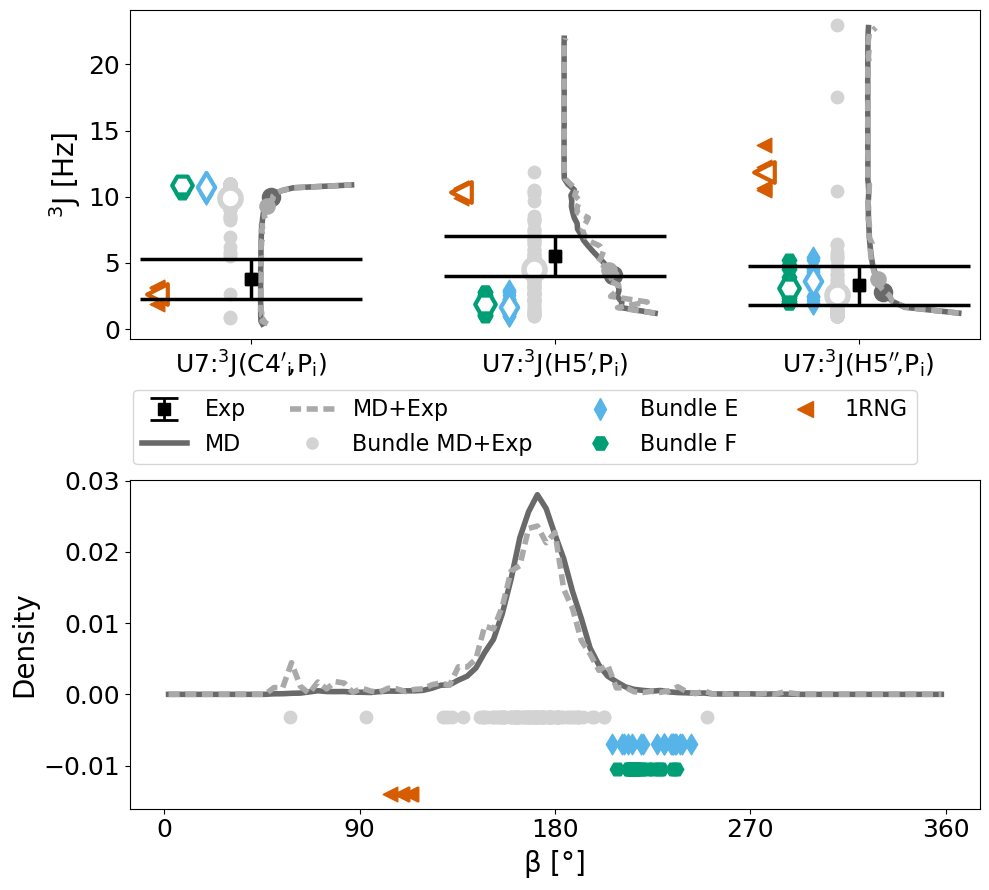

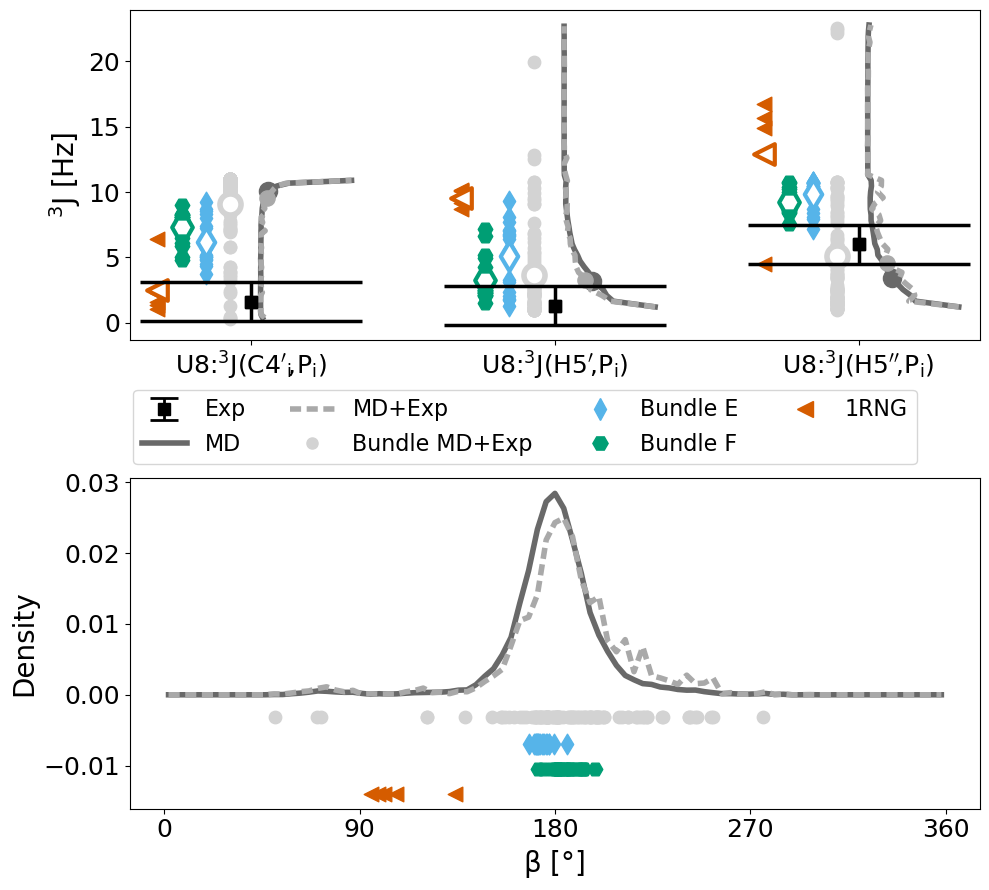

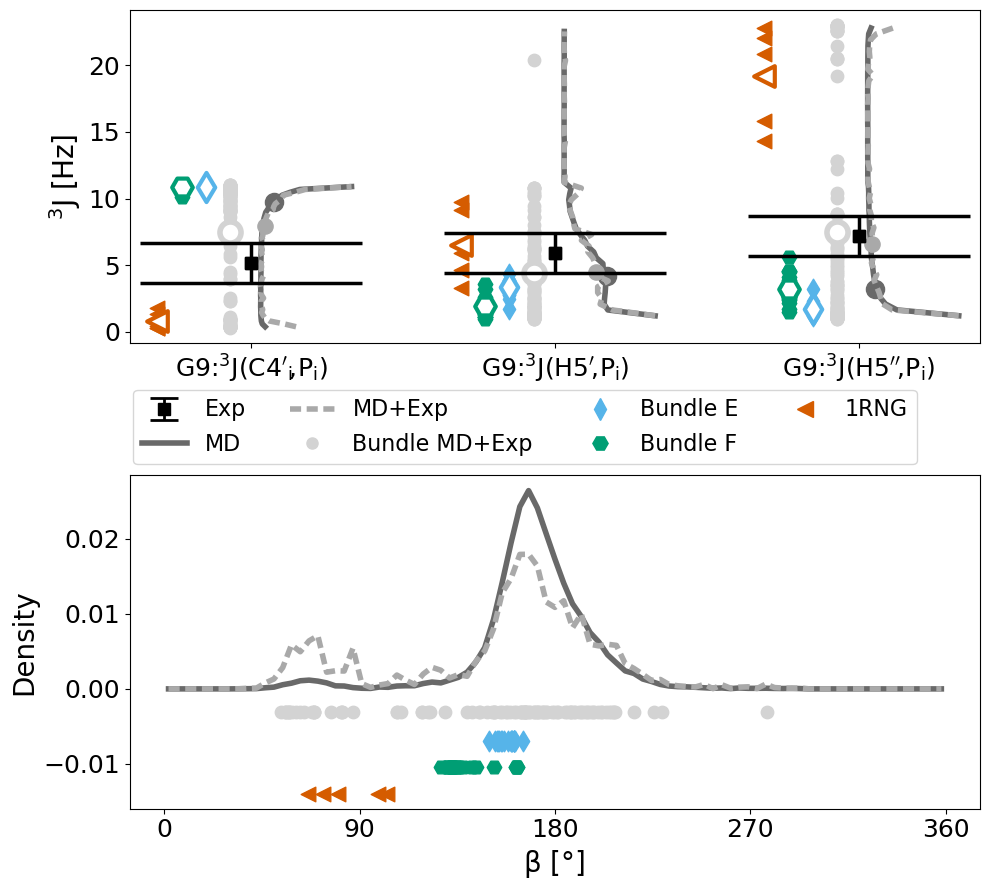

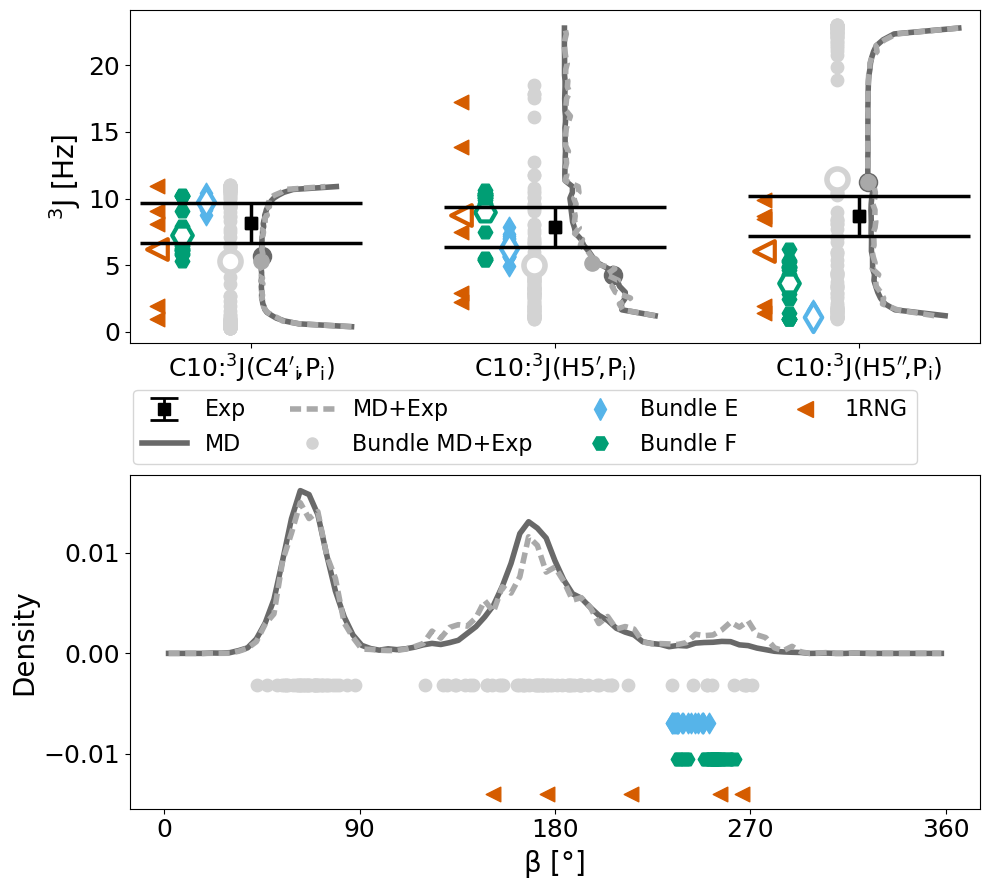

In [78]:
for i,r in enumerate(['G5', 'C6', 'U7', 'U8', 'G9', 'C10']):
    plot_angle_measurement_si(r, 'beta', ['C4Pb', '1H5P', '2H5P'], 'j3', save=True)

## $\gamma$

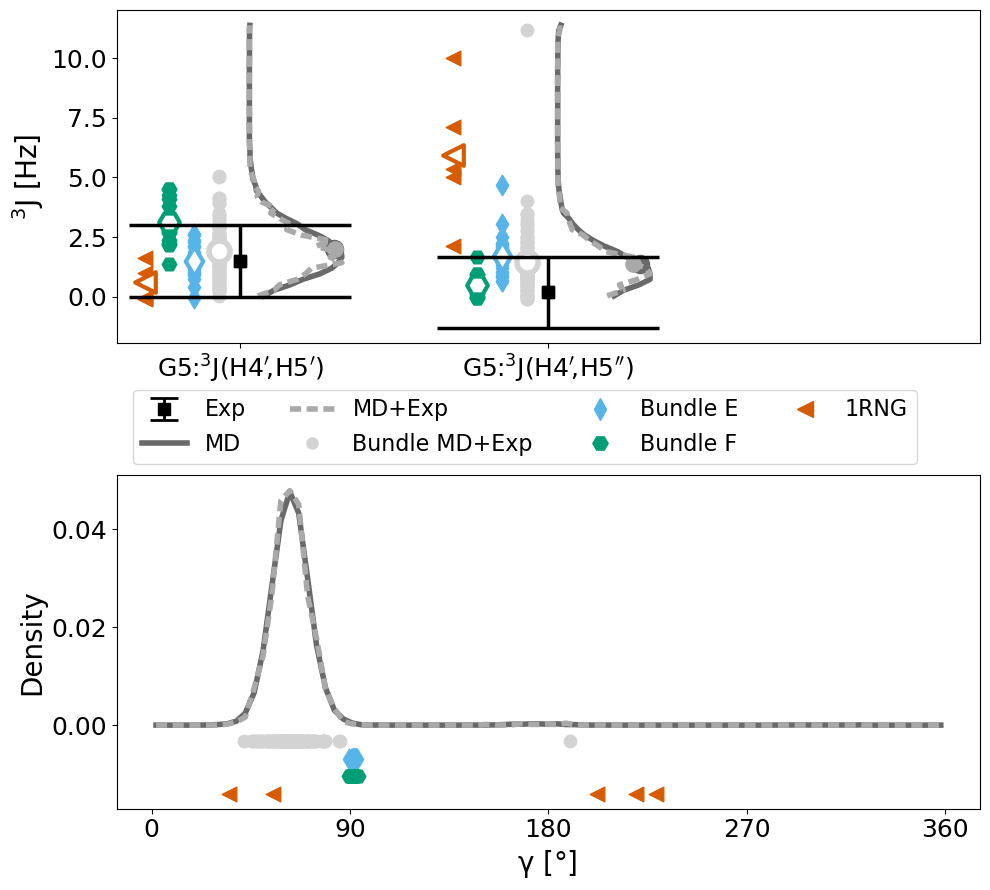

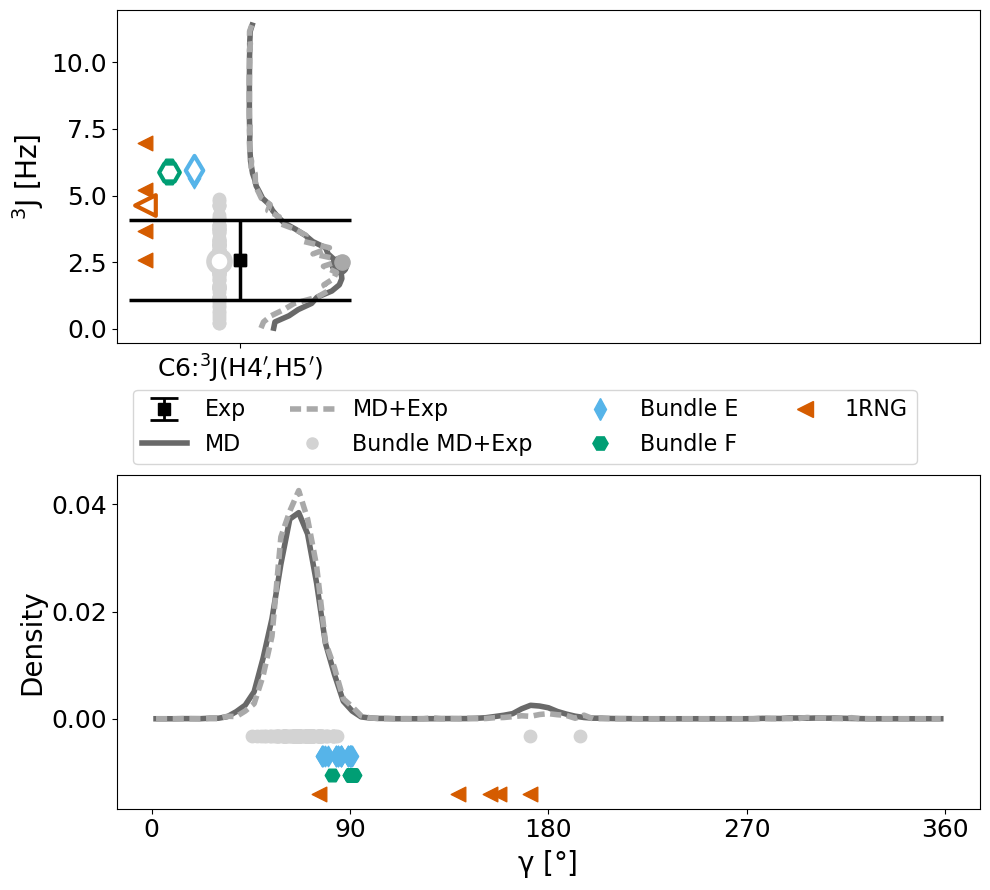

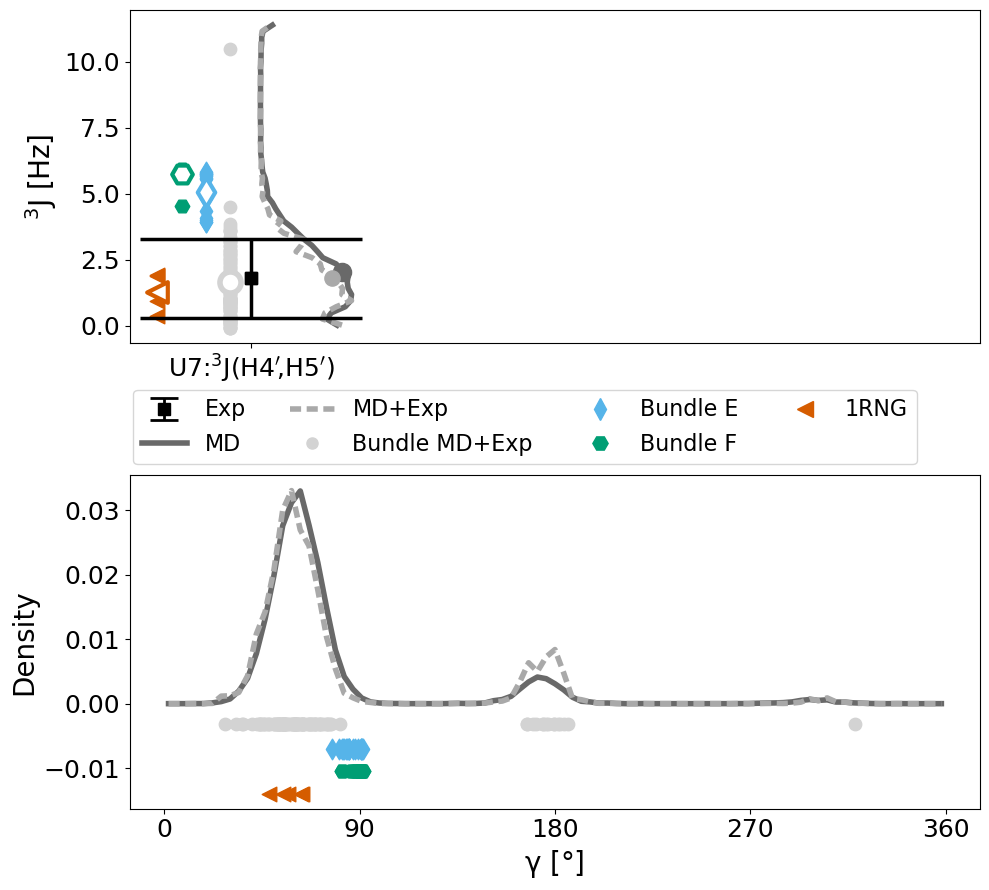

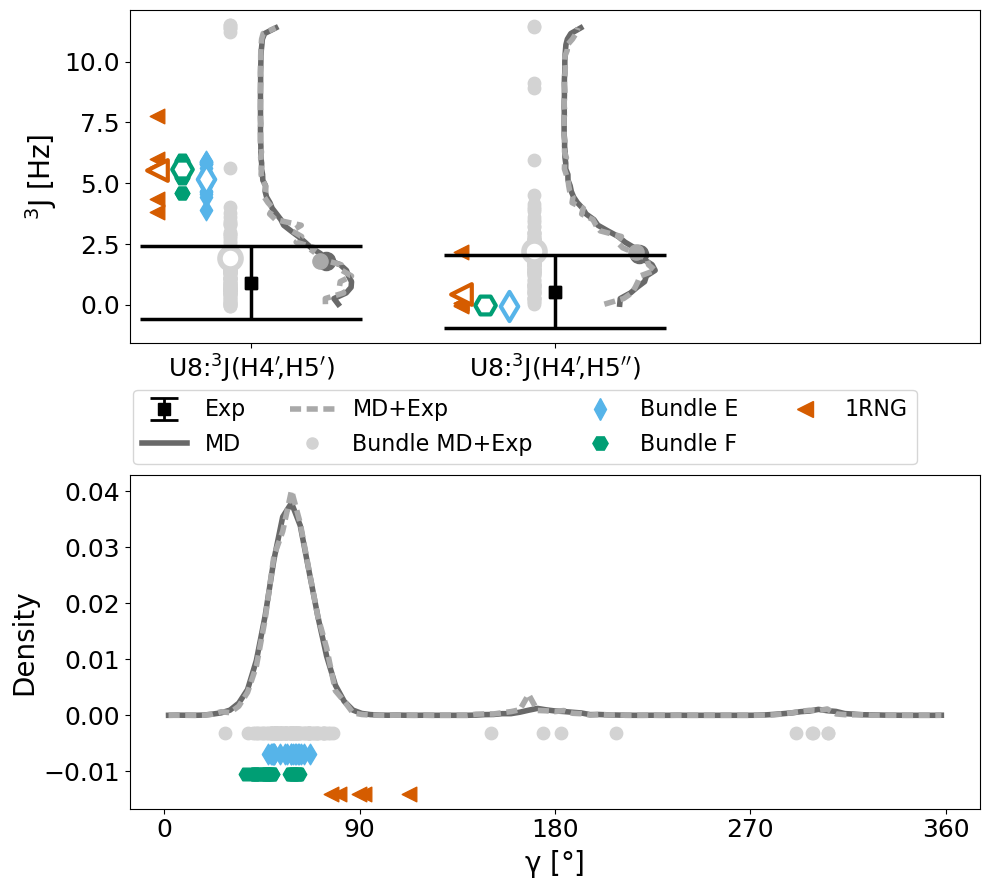

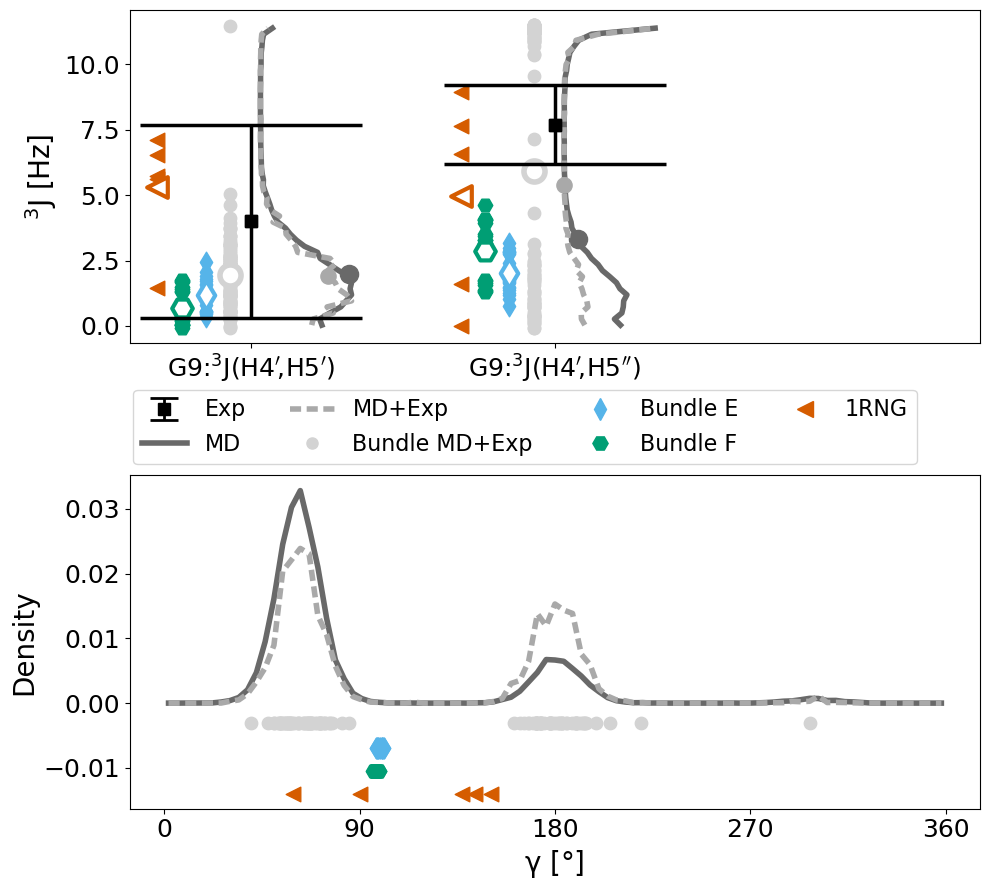

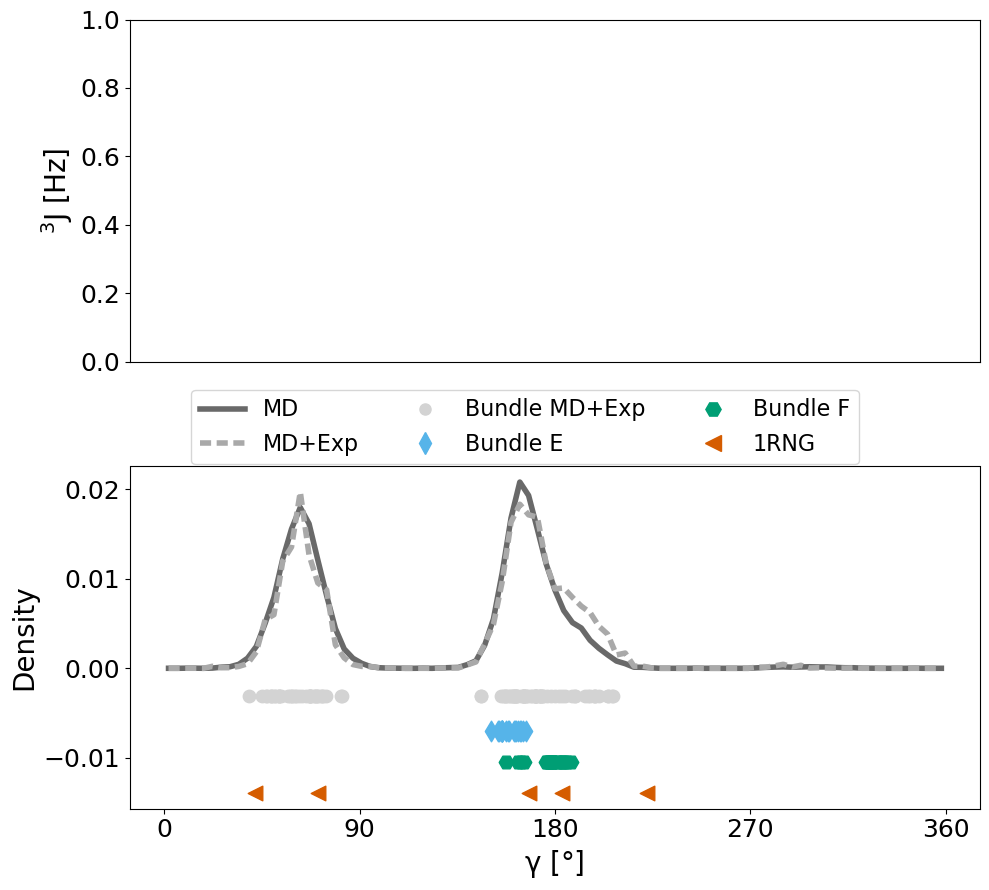

In [79]:
for i,r in enumerate(['G5', 'C6', 'U7', 'U8', 'G9', 'C10']):
    plot_angle_measurement_si(r, 'gamma', ['1H5H4', '2H5H4'], 'j3', save=True)

## $\delta$

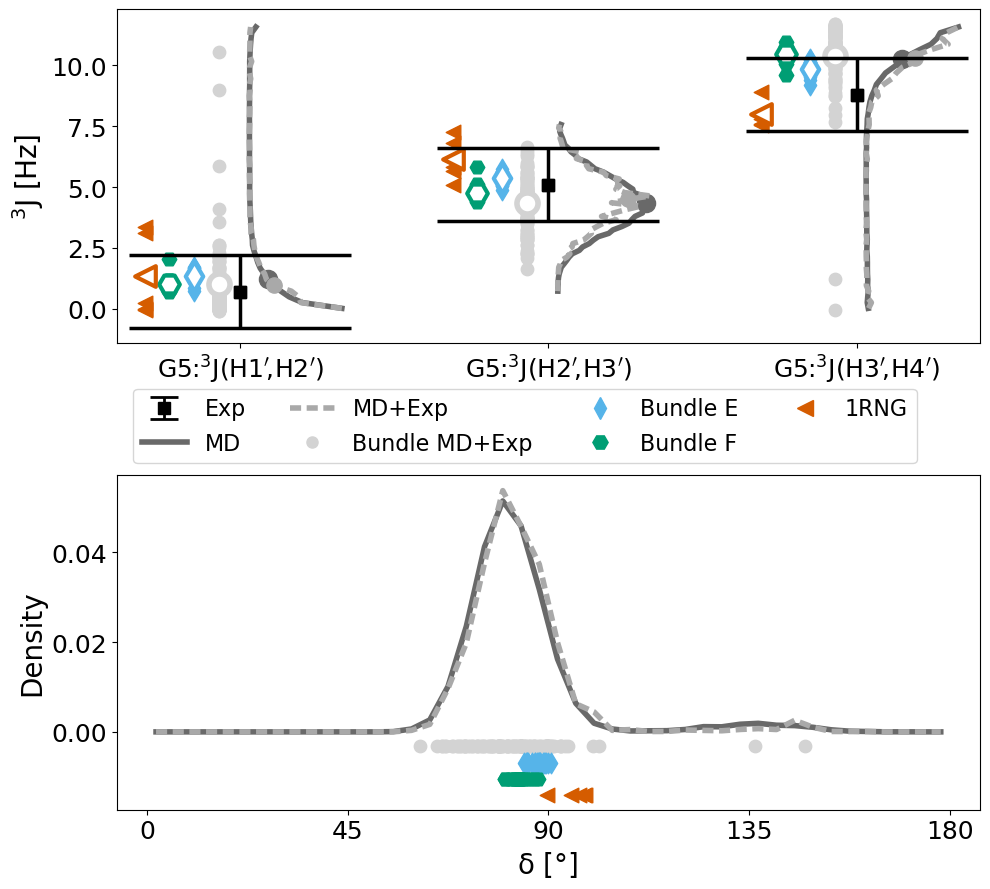

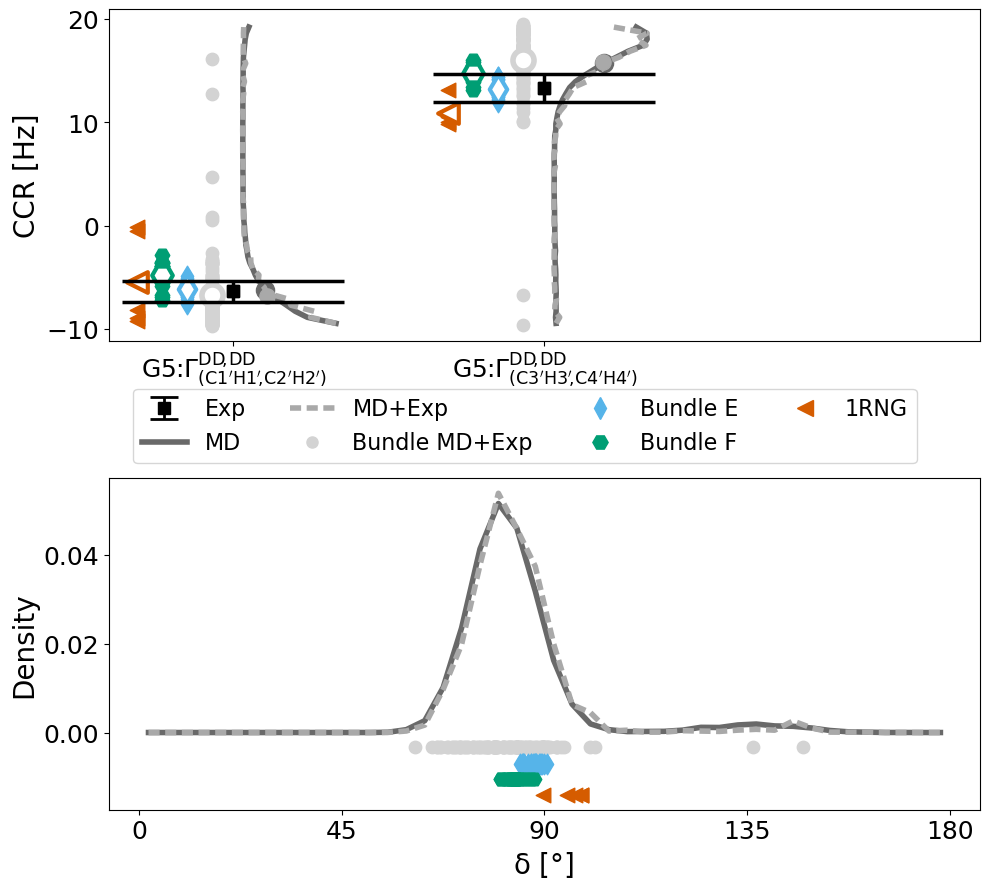

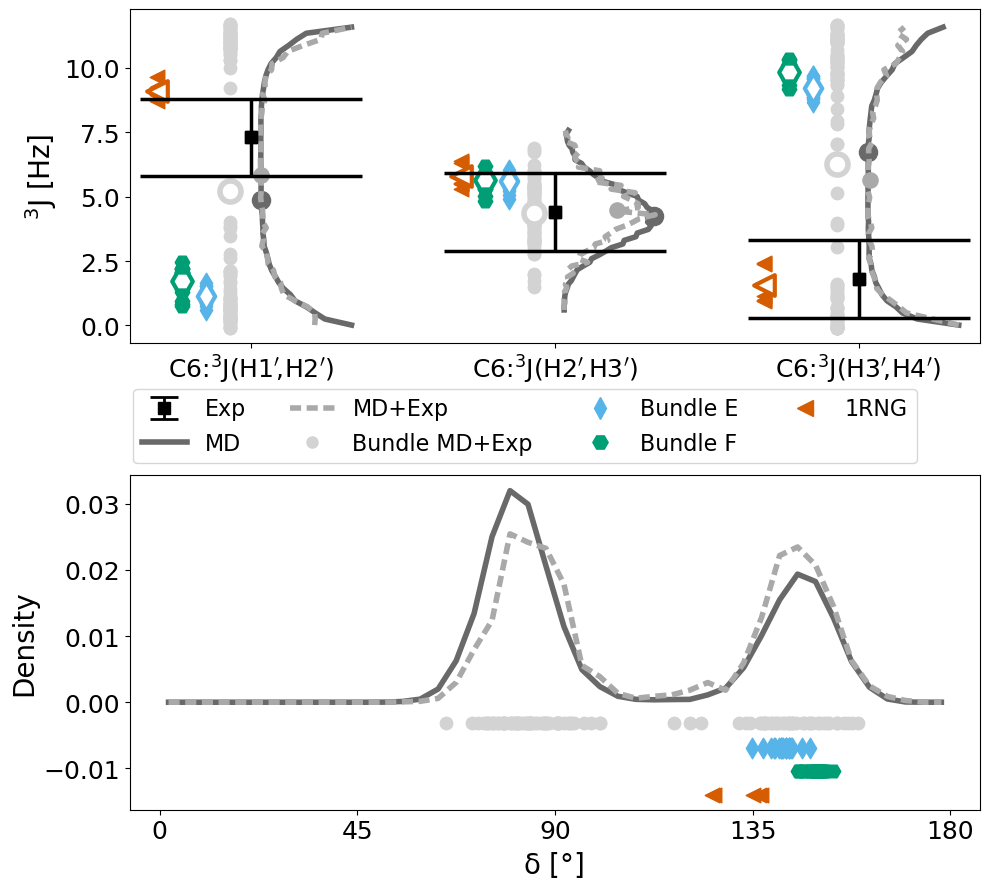

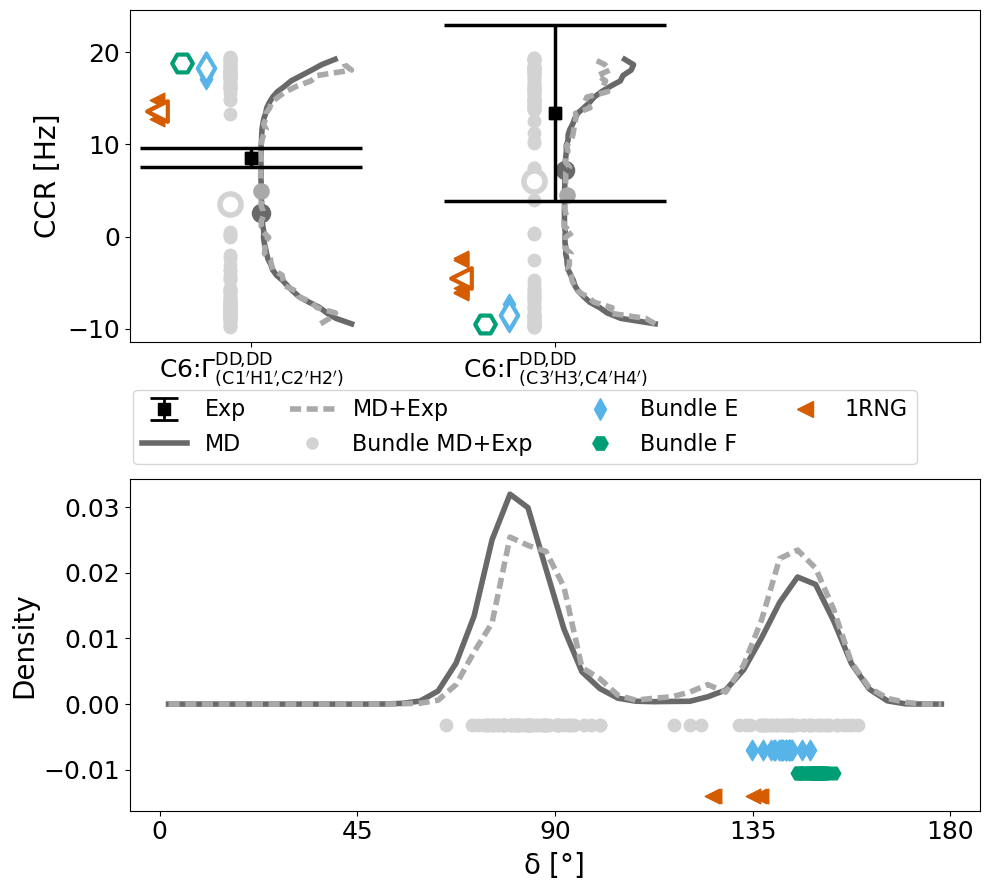

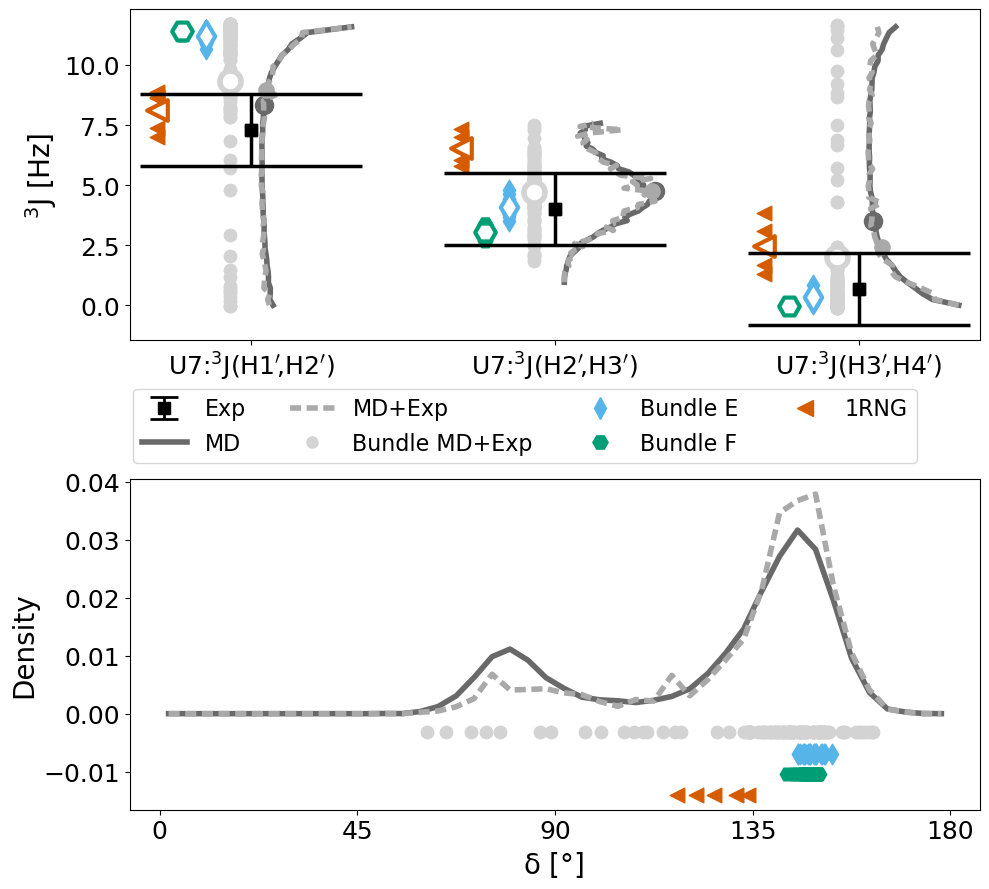

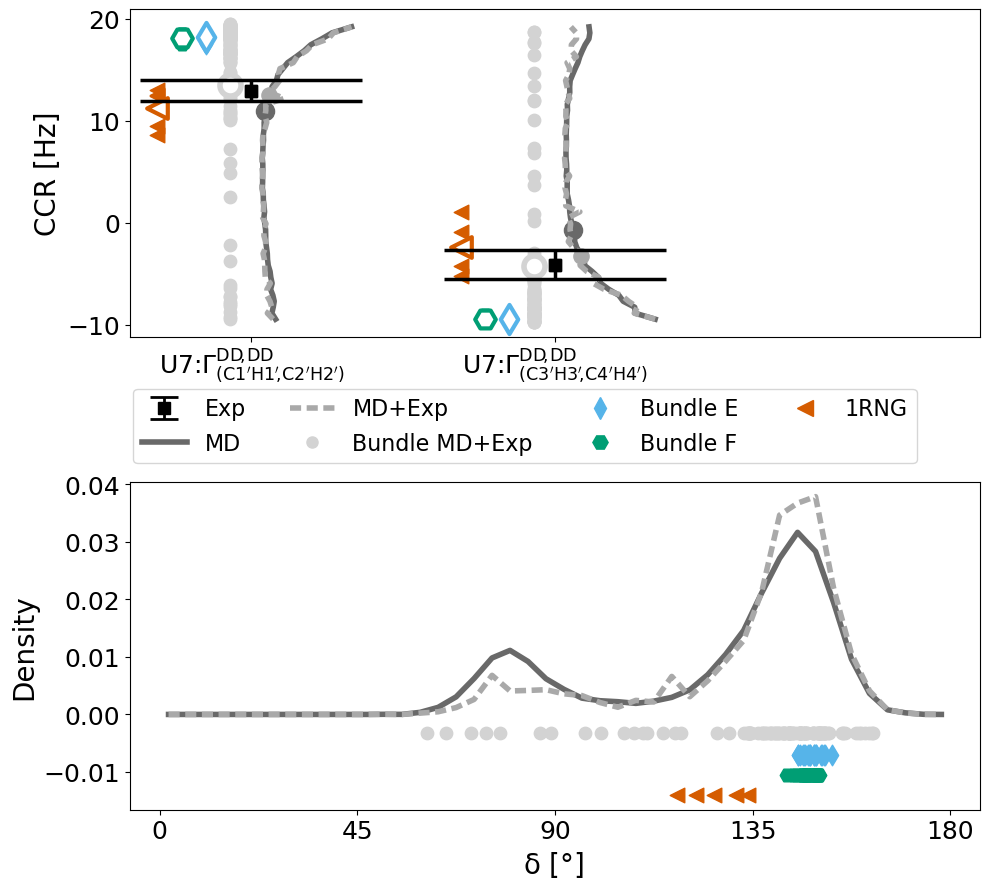

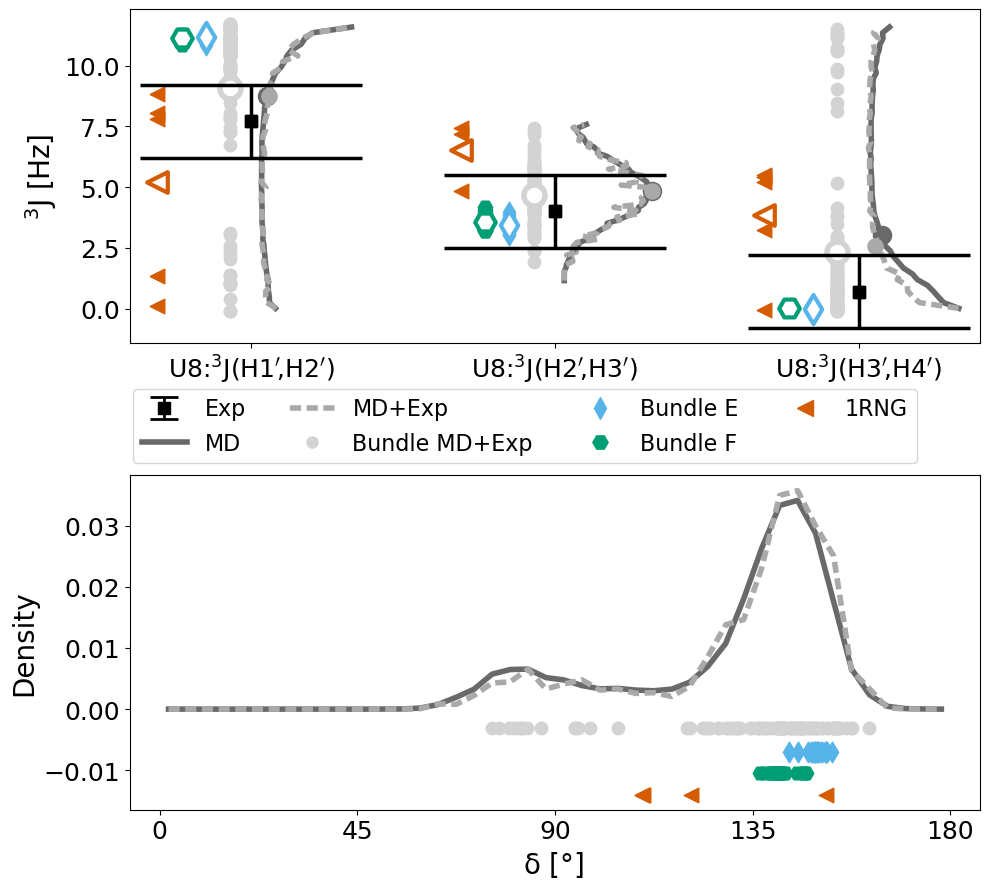

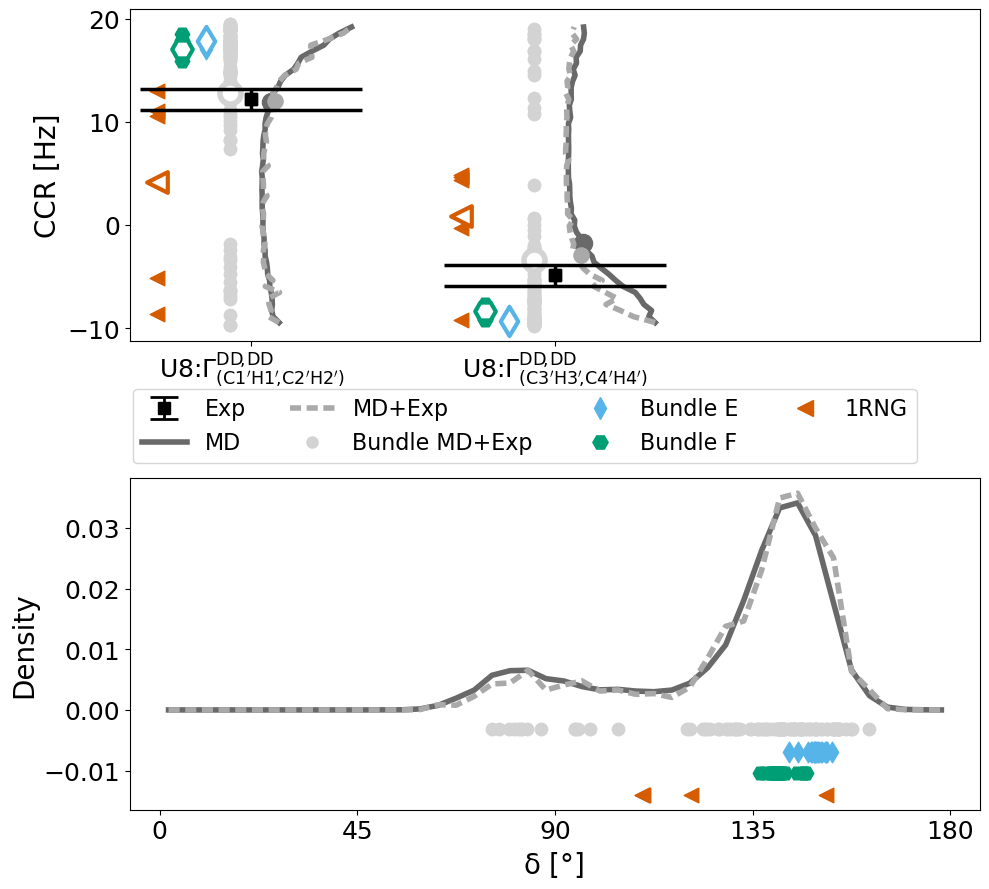

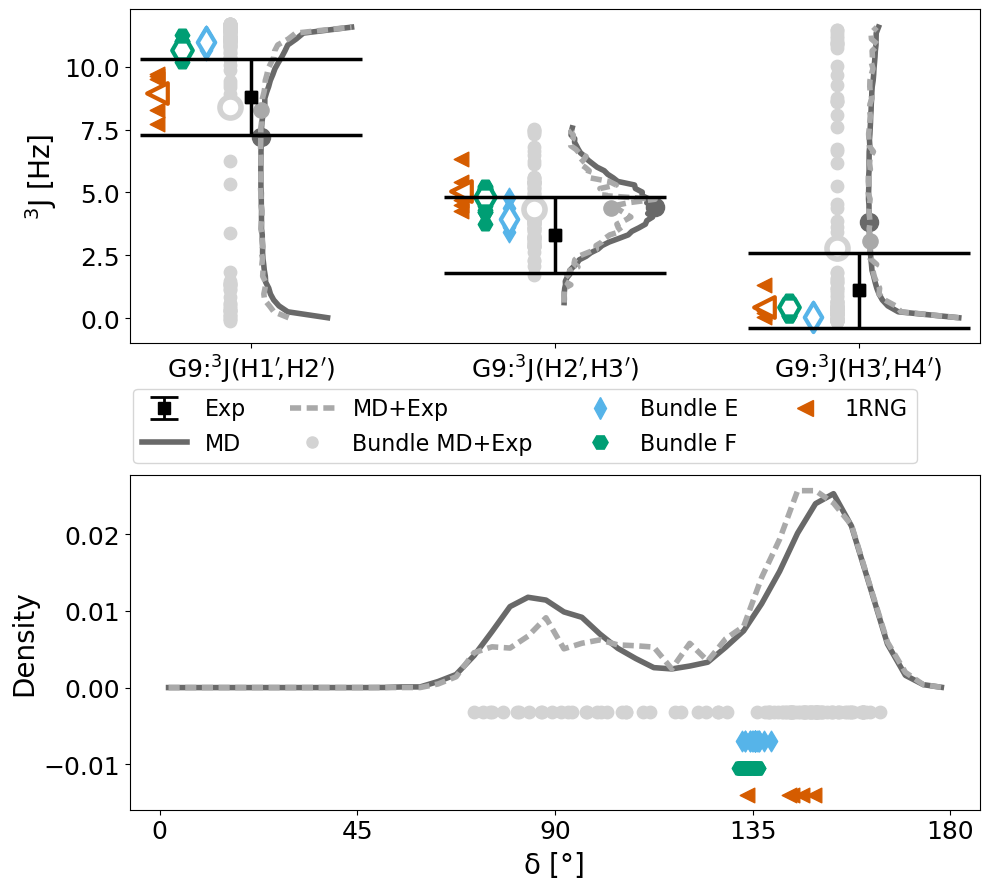

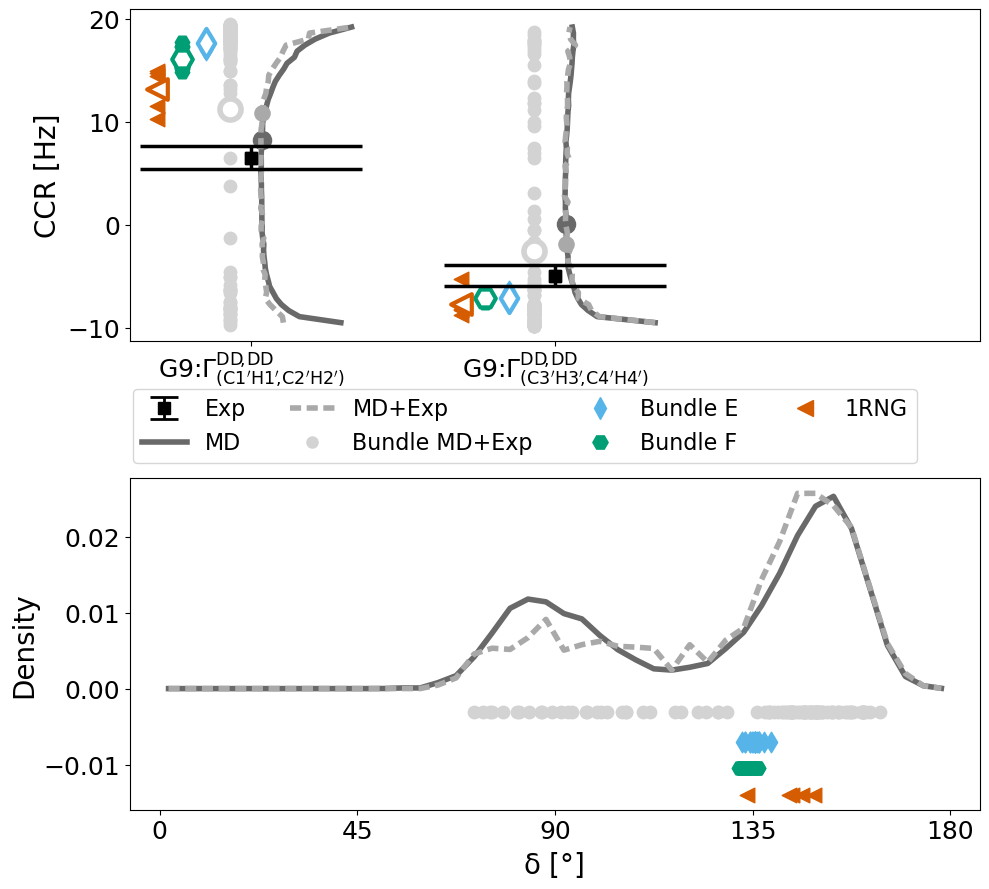

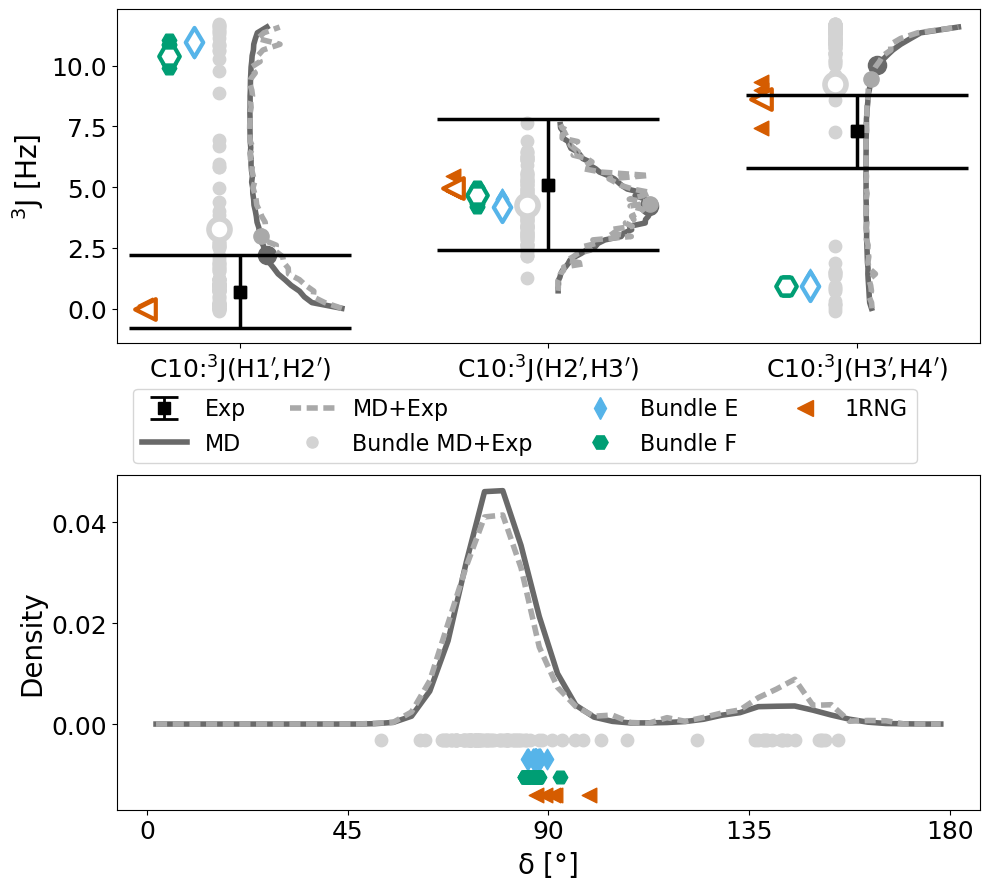

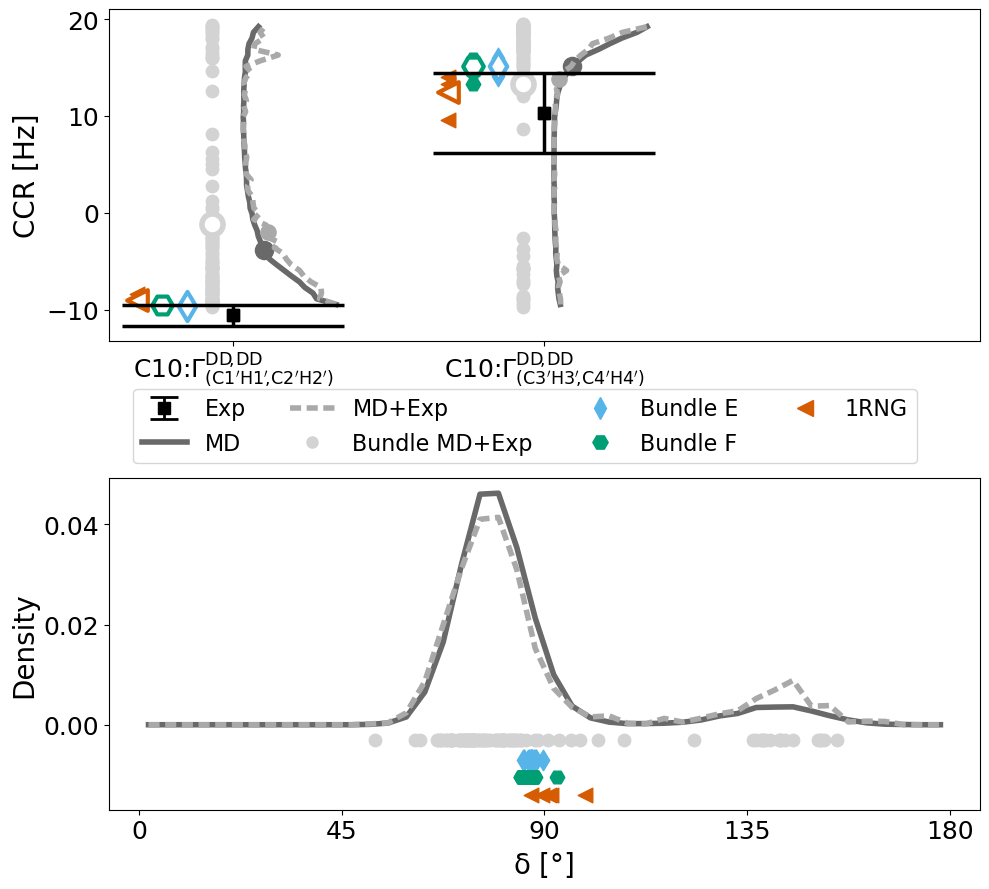

In [80]:
for i,r in enumerate(['G5', 'C6', 'U7', 'U8', 'G9', 'C10']):
    plot_angle_measurement_si(r, 'delta', ['H1H2', 'H2H3', 'H3H4'], 'j3', save=True)
    plot_angle_measurement_si(r, 'delta', ['C1-C2', 'C3-C4'], 'ccr', save=True)

## $\epsilon$

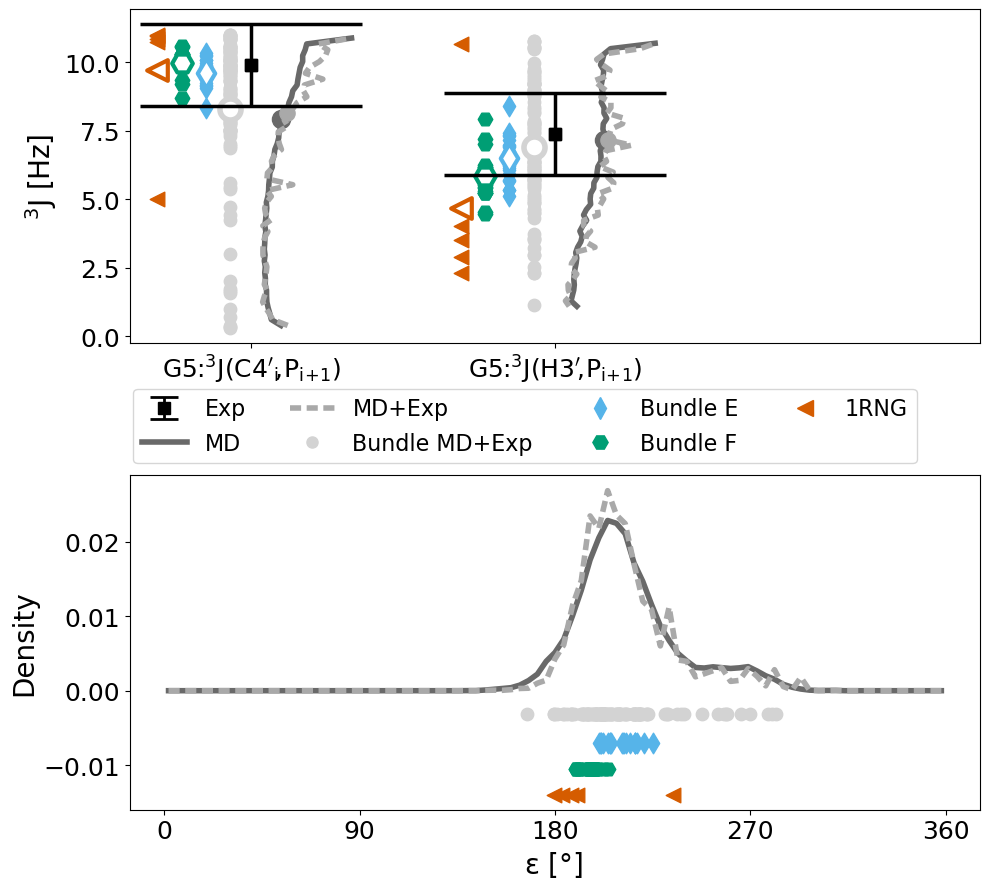

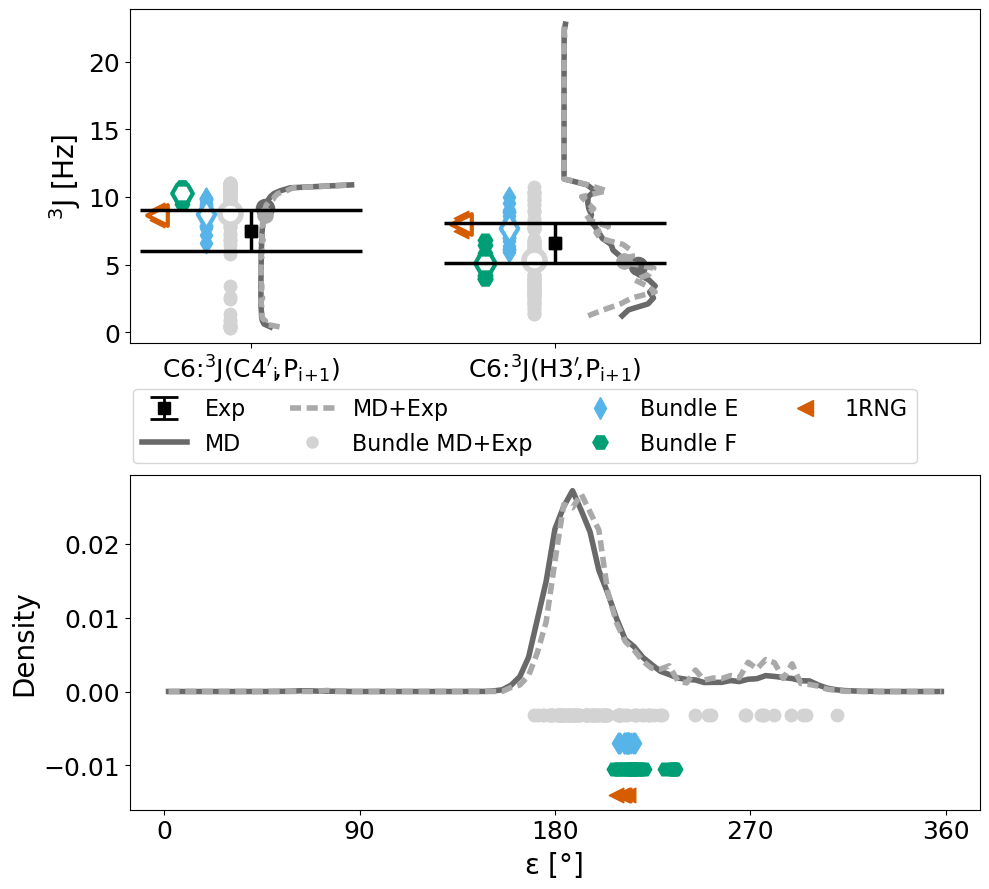

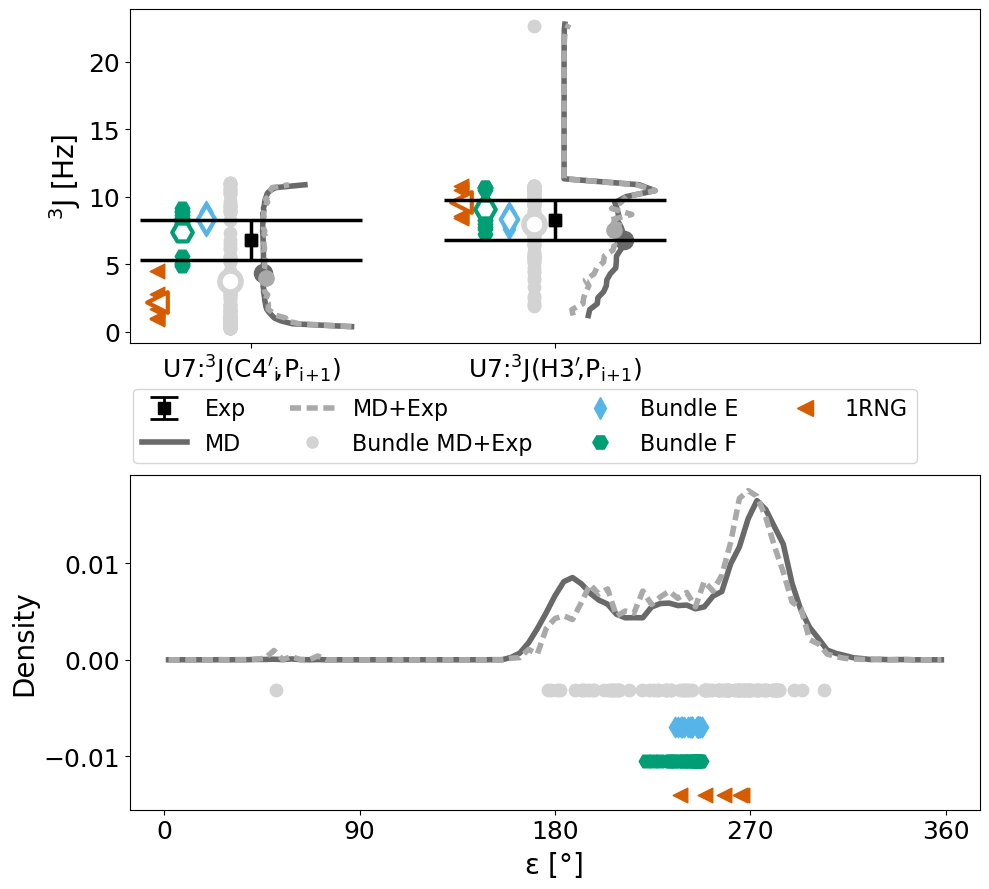

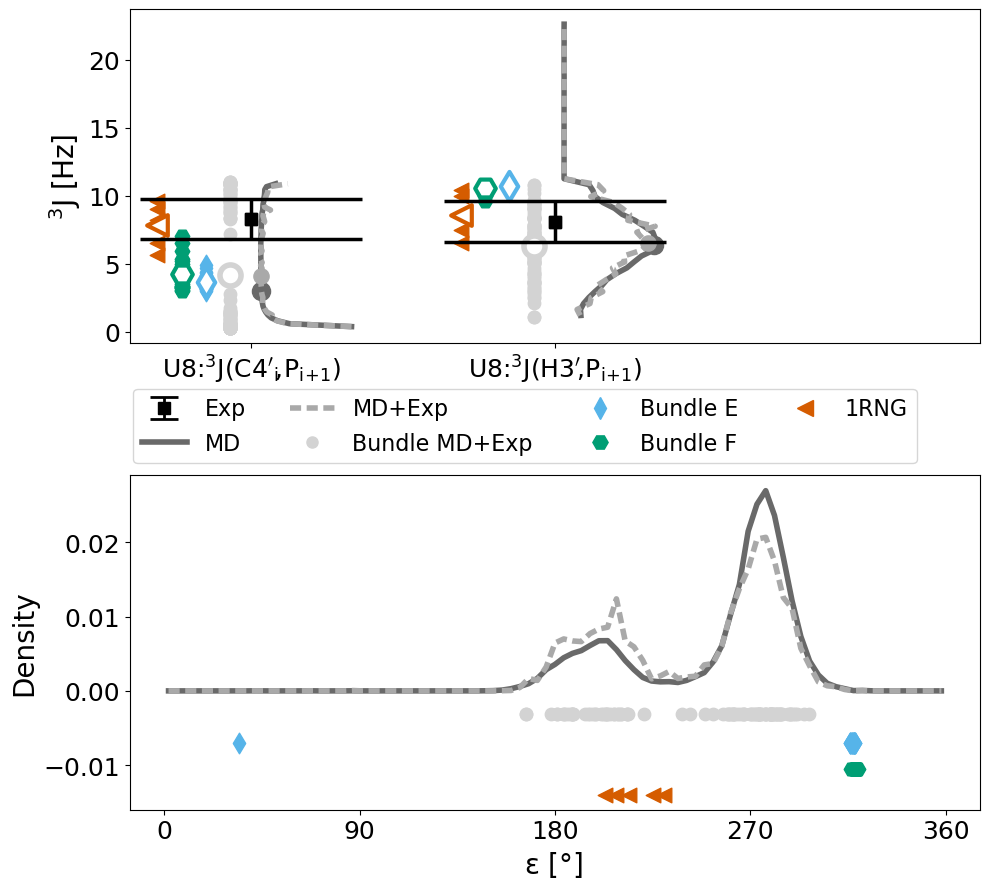

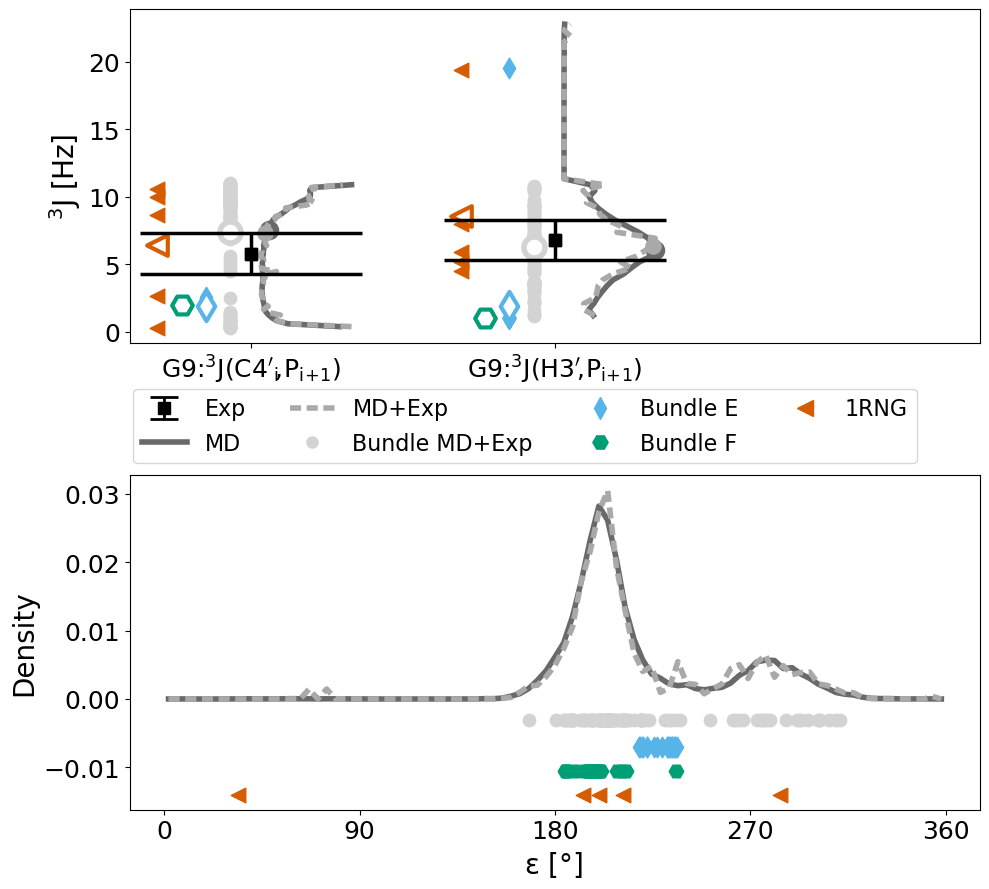

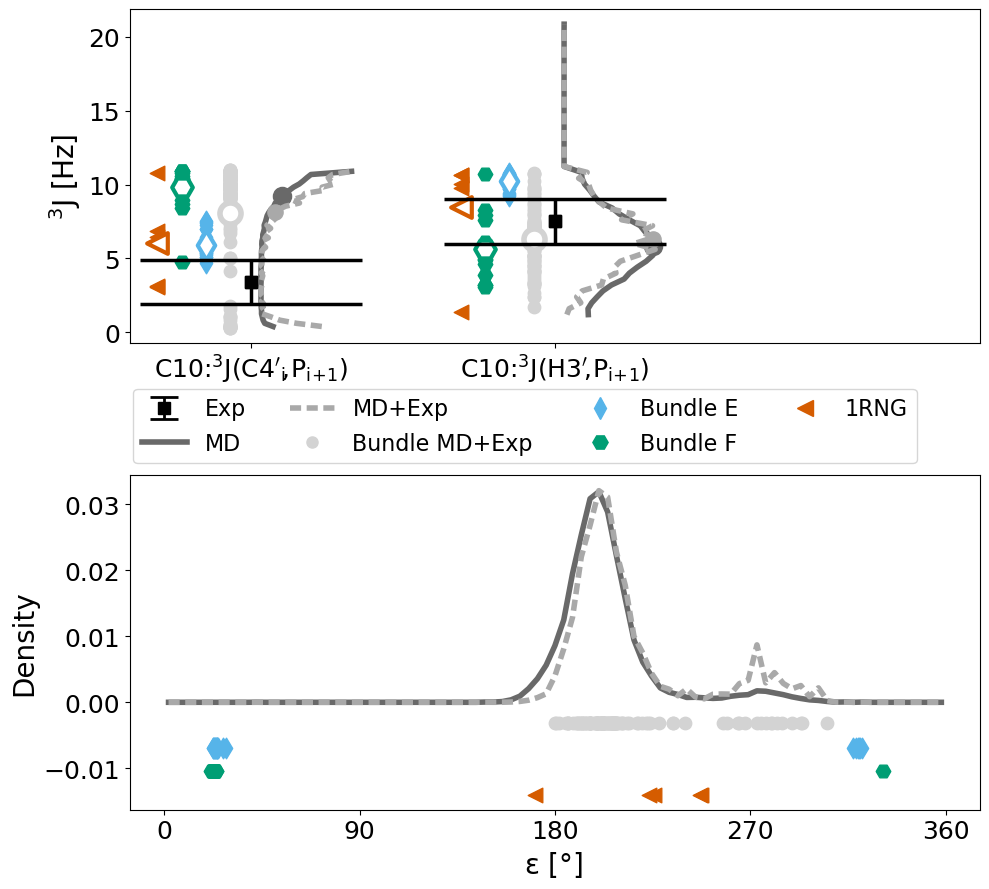

In [81]:
for i,r in enumerate(['G5', 'C6', 'U7', 'U8', 'G9', 'C10']):
    plot_angle_measurement_si(r, 'eps', ['C4Pe', 'H3P'], 'j3', save=True)

## $\zeta$

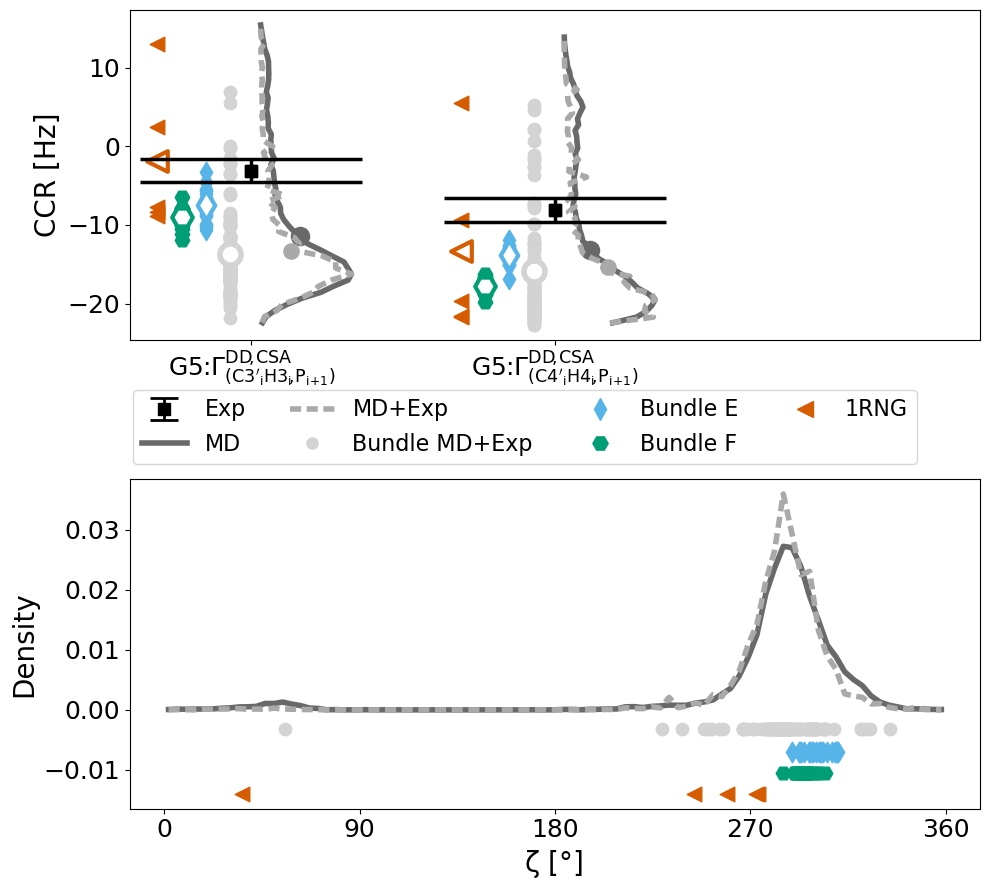

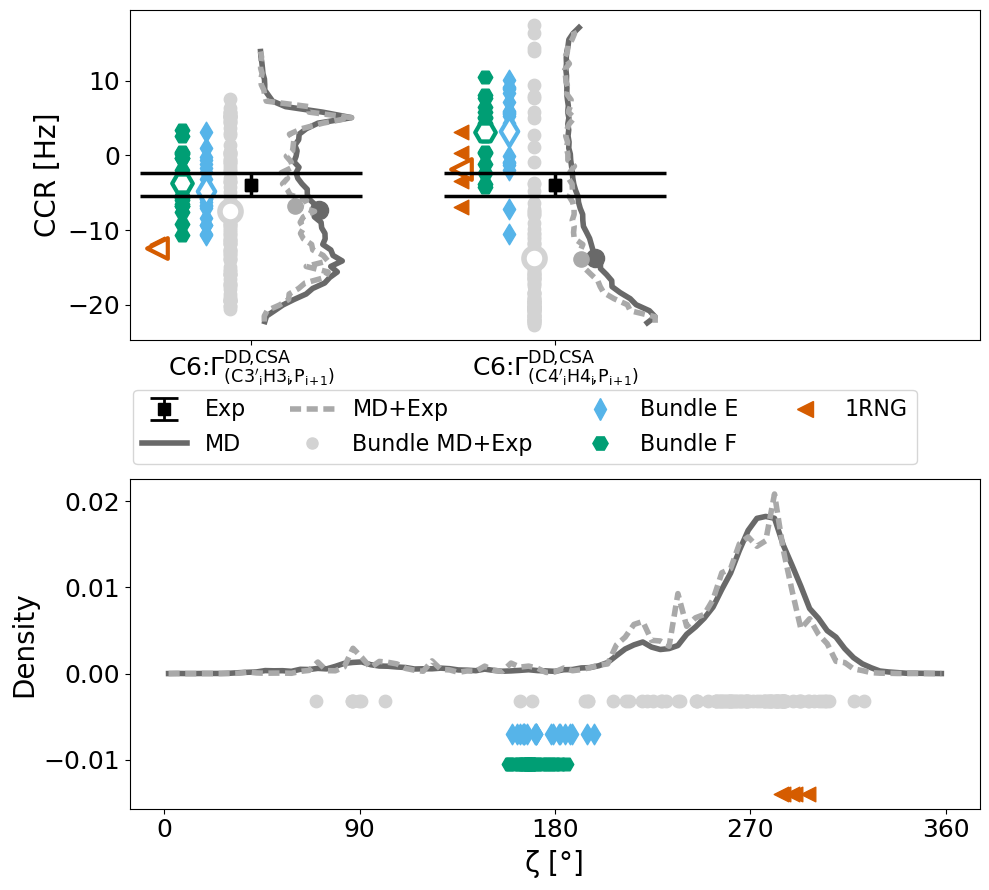

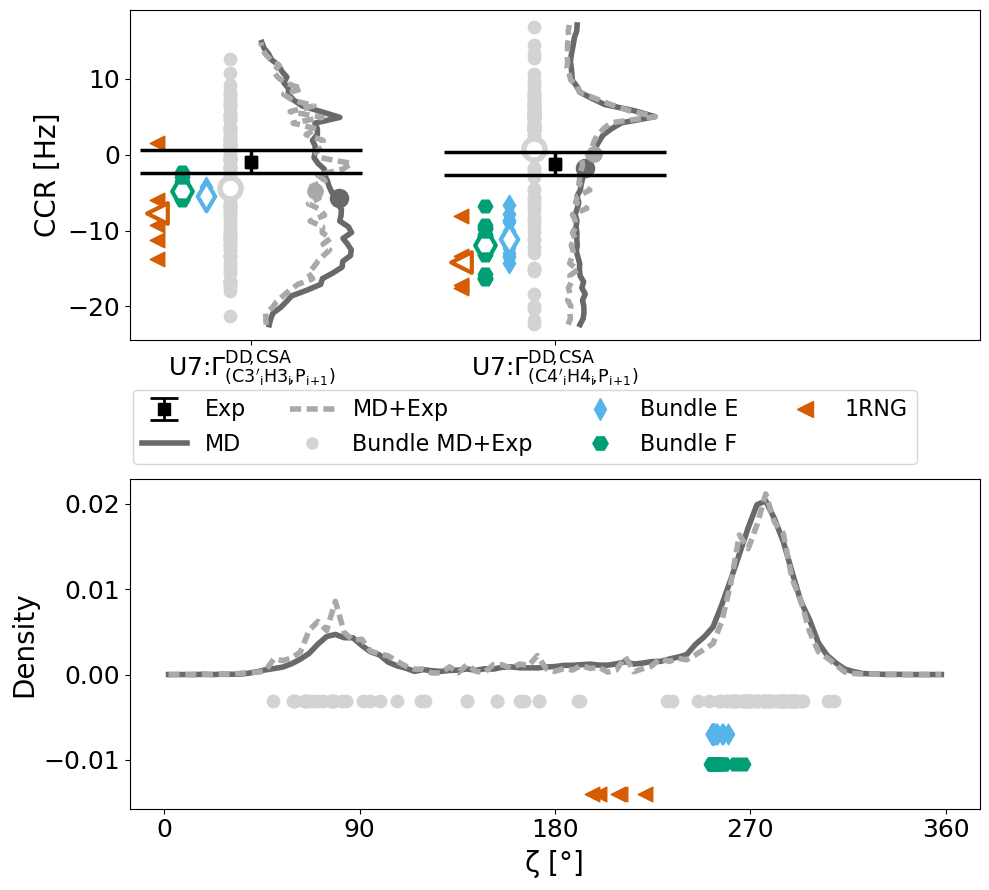

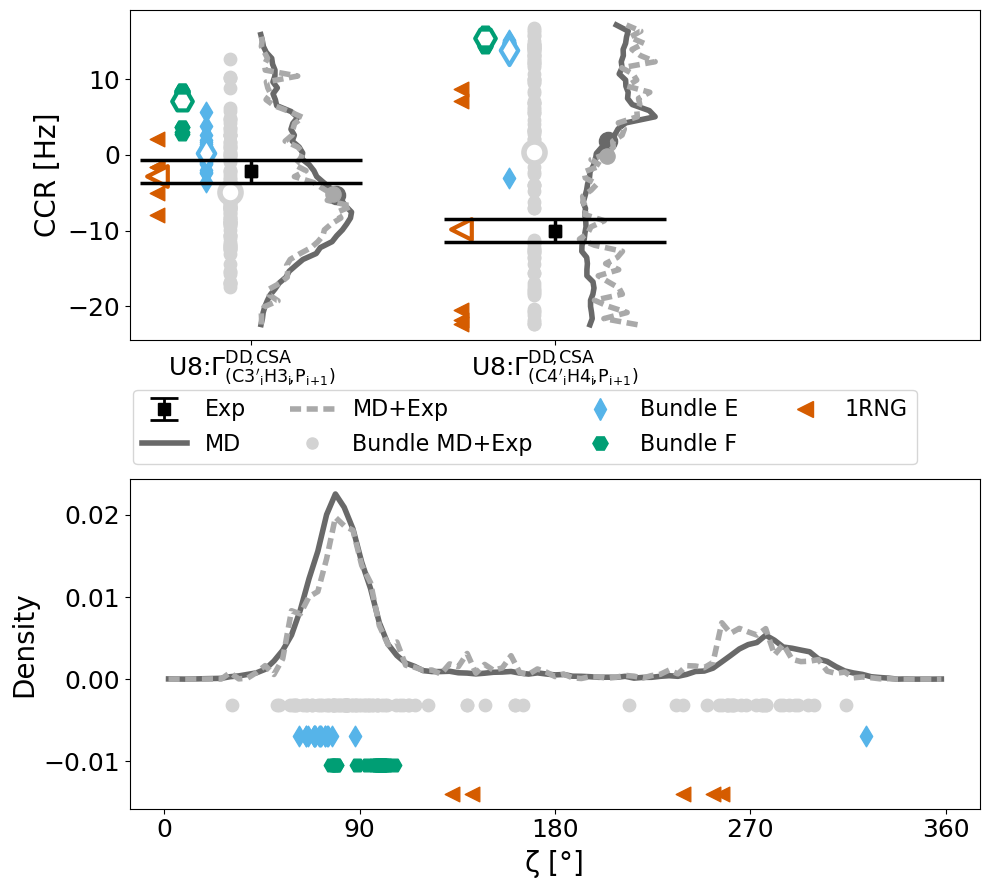

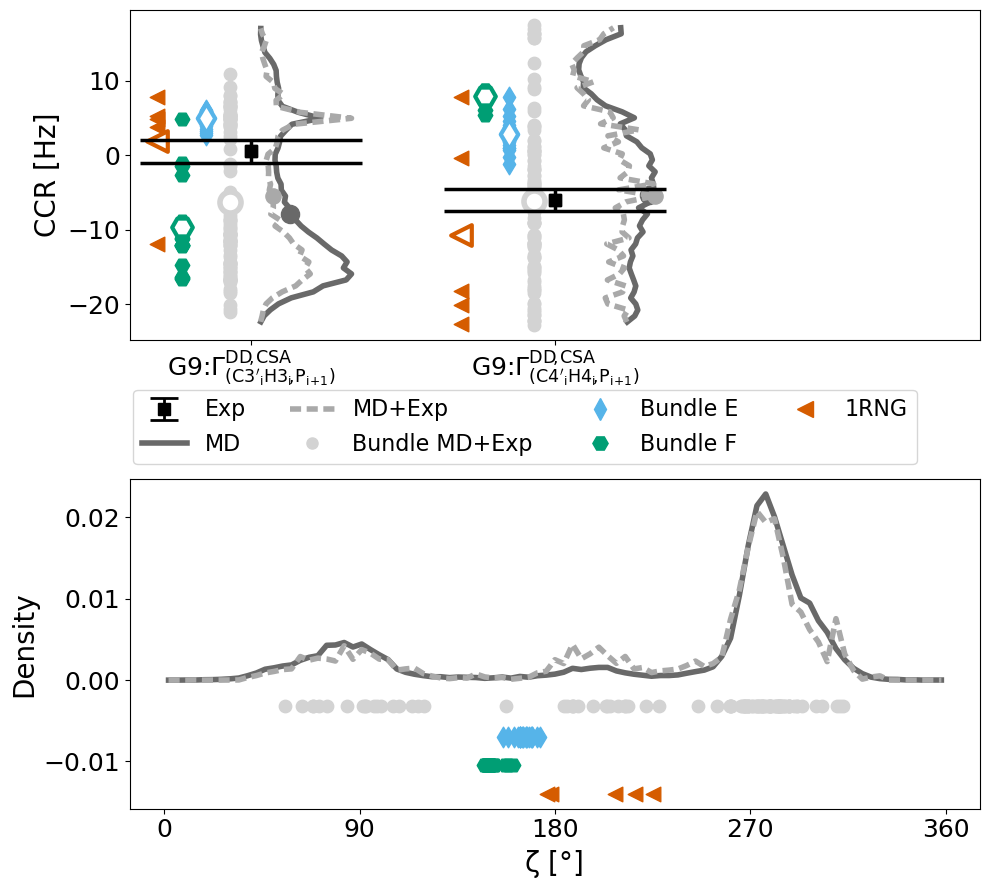

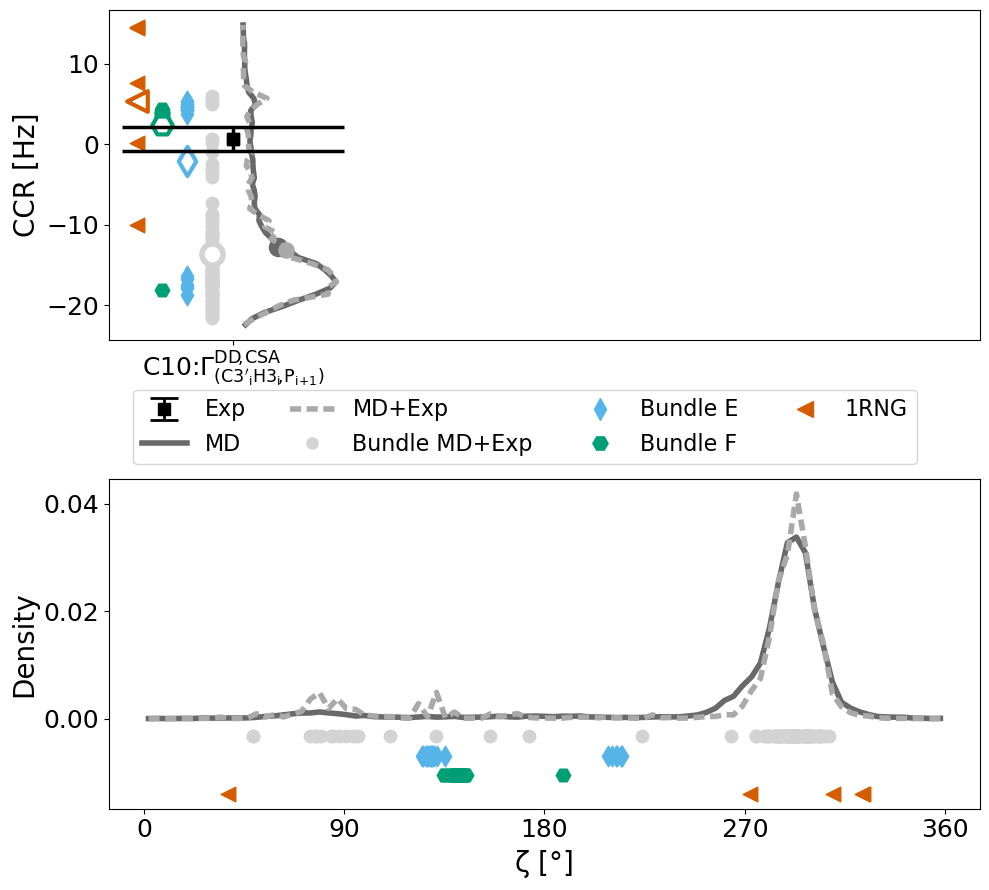

In [82]:
for i,r in enumerate(['G5', 'C6', 'U7', 'U8', 'G9', 'C10']):
    plot_angle_measurement_si(r, 'zeta', ['C3p-P-plus', 'C4p-P-plus'], 'ccr', save=True)